# Deep Learning - Exercise 1
---
## Ilias Katsampalos
Product Recognition using the fashion-mnist dataset from Zalando.

In [ ]:
import numpy as np
import pandas as pd
from plotnine import *
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(palette='deep', color_codes=True, font_scale=1.3)
from tensorflow.keras import backend as K, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.random import set_seed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import os.path
import json
from scipy.special import softmax


np.random.seed(1993)
set_seed(1993)

# 1. The data
---
The first step is to clone the repository in order to retrieve the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 758, done.
remote: Total 758 (delta 0), reused 0 (delta 0), pack-reused 758
Receiving objects: 100% (758/758), 105.84 MiB | 42.17 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [ ]:
%cd fashion-mnist

/content/fashion-mnist


In [ ]:
from utils import mnist_reader
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

We will also set the variable `N` with the dimension of the image, as well as the variable `N_CLASSES` denoting the number of classes in our multiclass problem.

In [ ]:
N=28
N_CLASSES = 10

Lastly, the labels for our dataset are:

In [ ]:
label_descr = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",7:"Sneaker",8:"Bag",9:"Ankle boot"}

# 2. EDA
---
First, the distribution of the classes needs to be checked in both the train and the test set.

From the train set, a uniform distribution is observed among all the classes.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


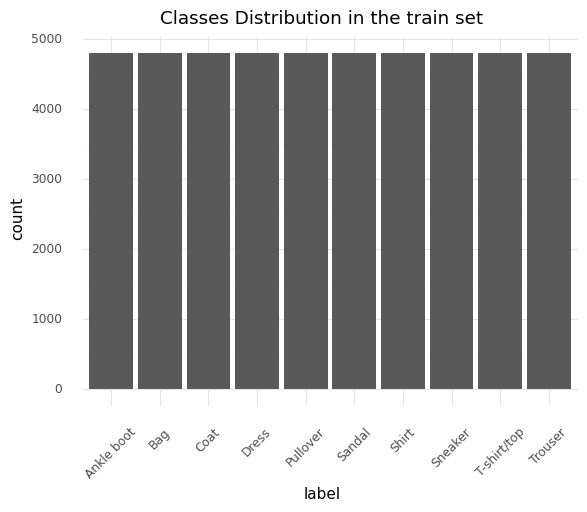

<ggplot: (8772952229245)>

In [ ]:
y_train_df = pd.DataFrame(y_train, columns=["label"])
y_train_df["label_descr"] = y_train_df.label.apply(lambda x: label_descr[x])

(ggplot(y_train_df) +
    geom_bar(aes(x='label_descr')) +
    ggtitle("Classes Distribution in the train set") +
    xlab("label") +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45))
)

The same uniform distribution is observed in the test as well.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


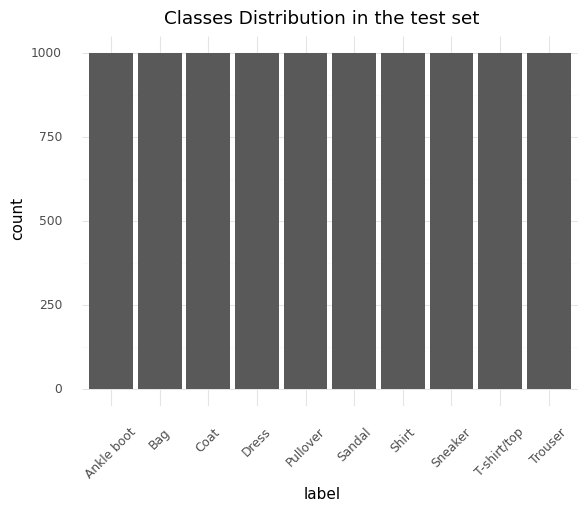

<ggplot: (8772954499093)>

In [ ]:
y_test_df = pd.DataFrame(y_test, columns=["label"])
y_test_df["label_descr"] = y_test_df.label.apply(lambda x: label_descr[x])

(ggplot(y_test_df) +
    geom_bar(aes(x='label_descr')) +
    ggtitle("Classes Distribution in the test set") +
    xlab("label") +
    theme_minimal() +
    theme(axis_text_x=element_text(angle=45))
)

Next, for each class we will plot 3 examples from the train set and three from the test set

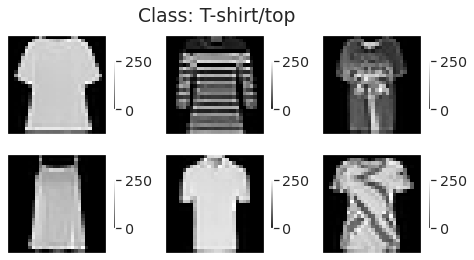

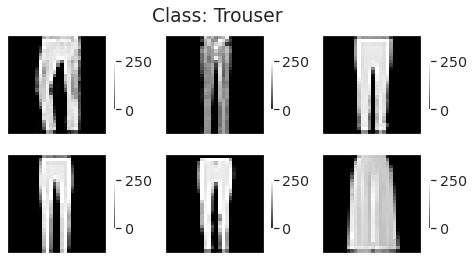

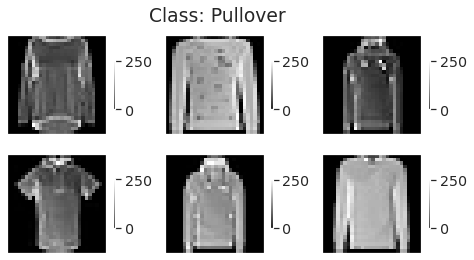

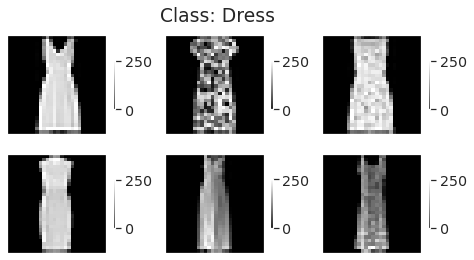

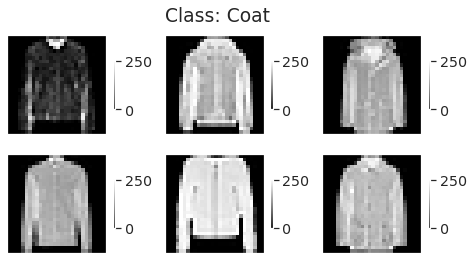

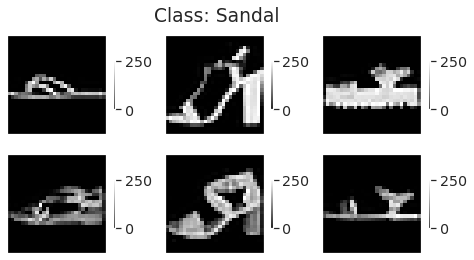

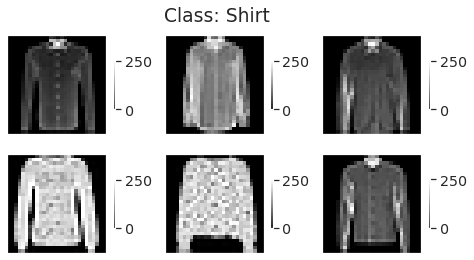

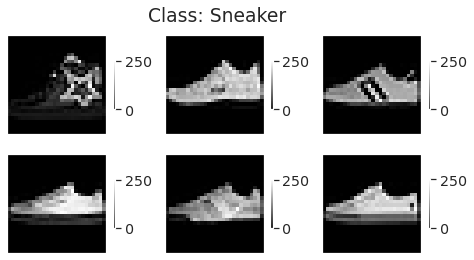

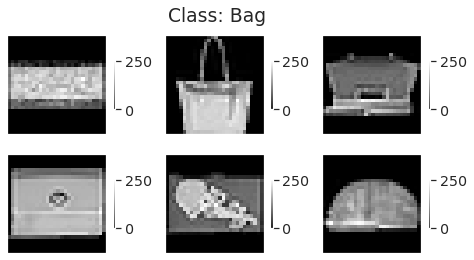

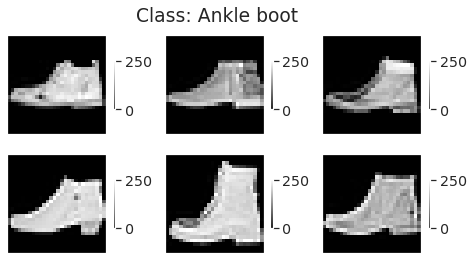

In [ ]:
for label, label_name in label_descr.items():
    train_ids = np.where(y_train==label)[0]
    train_samples = np.random.choice(train_ids,size=3)
    test_ids = np.where(y_test==label)[0]
    test_samples = np.random.choice(test_ids,size=3)

    fig, axs = plt.subplots(2,3, figsize=(8,4))
    for id, ax in zip(train_samples, axs[0,:]):
        im = X_train[id].reshape(N,N)
        im_plot = ax.imshow(im, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        handles, labels = ax.get_legend_handles_labels()
        fig.colorbar(im_plot, ax=ax, shrink=.5)
    for id, ax in zip(test_samples, axs[1,:]):
        im = X_test[id].reshape(N,N)
        im_plot = ax.imshow(im, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        handles, labels = ax.get_legend_handles_labels()
        fig.colorbar(im_plot, ax=ax, shrink=.5)
    fig.suptitle("Class: " + label_name)

We observe that in the greyscale channel that we have, all pixels are scaled from `0` to `255`. Normalizing the scale before providing them as input to a neural network might prove to be beneficial.

# Preprocessing
---

## Validation Set
We will hold out a part of the training set in order to tune the hyperparameters of the model.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, stratify=y_train)

## Labels One-hot encoding
Since we face a multiclass classification problem, the labels for both the train set as well as the test set will need to be converted to `one hot encoding`

In [ ]:
y_train_one_hot = to_categorical(y_train, num_classes=N_CLASSES)
y_val_one_hot = to_categorical(y_val, num_classes=N_CLASSES)
y_test_one_hot = to_categorical(y_test, num_classes=N_CLASSES)

## Normalization

For normalization of the input we will experiment with two options. 

### Min-Max Scaling
The first option is to apply the `min max scaling` technique to every image
$$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$$
where $X_{min}$  and $X_{max}$ is the minimum and maximum intensity of each image respectively. 

From the plots above, we observed that each image scales from 0 to 255, thus the formula can be reexpressed as:
$$X_{norm} = \frac{X}{255}$$

In [ ]:
def min_max_scaling(X):
    return X/255

Plotting one example we obtain:

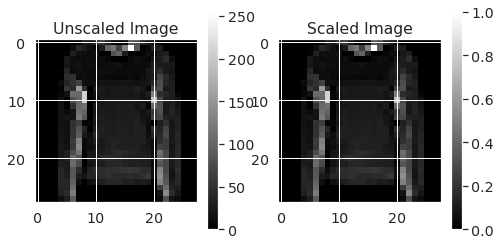

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,8))
unscaled = axs[0].imshow(X_train[0].reshape(N,N), cmap="gray")
axs[0].title.set_text("Unscaled Image")
fig.colorbar(unscaled, ax=axs[0], shrink=.5)

scaled = axs[1].imshow(min_max_scaling(X_train[0].reshape(N,N)), cmap="gray")
axs[1].title.set_text("Scaled Image")
fig.colorbar(scaled, ax=axs[1], shrink=.5)

plt.show()

As expected, the image has not been distorted. Only the scale changed from `[0-255]` to `[0-1]`

### Global Contrast Normalization
The second option is to use the Global Contrast Normalization

$$X = s \frac{X - X_{mean}}{max[\epsilon, \sqrt{\lambda + \frac{1}{N^2} X^TX}]}$$

where $X_{mean}$ is the mean intensity of each image and N is the dimension which in our case is the same for both rows and columns

In [ ]:
def global_contrast_normalization(X, s, lamda, e):
    X = X - np.mean(X)
    std = X.T @ X / (N*N)
    X = s * X / max(e, np.sqrt(lamda + std))
    return X

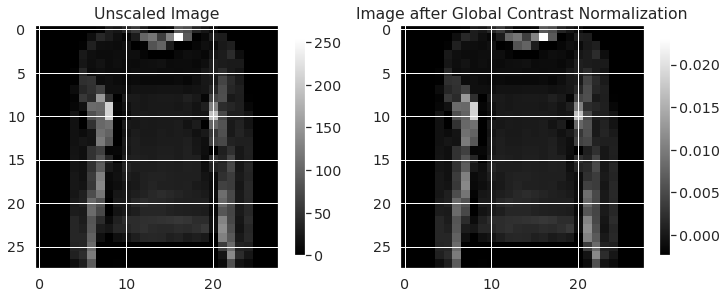

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,8))
unscaled = axs[0].imshow(X_train[0].reshape(N,N), cmap="gray")
axs[0].title.set_text("Unscaled Image")
fig.colorbar(unscaled, ax=axs[0], shrink=.5)

gcn = global_contrast_normalization(X_train[0], 10, 20, 1e5)
scaled = axs[1].imshow(gcn.reshape(N,N), cmap="gray")
axs[1].title.set_text("Image after Global Contrast Normalization")
fig.colorbar(scaled, ax=axs[1], shrink=.5)

plt.show()

As we observe, there are not big differences in the image after the normalization was applied. We will experiment with this technique while training the models, although the tuning of the hyperparameters `s` and `lamda` add extra complexity in the hypertuning processs. 

# The ImageClassifier Class

A Parent class which implements the basic functions we will use, such as

* fit
* predict
* predict_class
* plot_history

In [ ]:
class ImageClassifier:
    '''
    Implements the following methods
        fit: trains a classifier and stores history
        plot_history: plots the convergence history of the fit
        predict_proba: returns the probability of belonging to a class
        predict_class: returns the class with the highest probability
        evaluate: calculate f1, precision and recall for the train, validation and test
        error_analysis: returns the confusion matrix and plots missclassified instances
    '''

    def __init__(self, name, model_id):
        '''
        Constructor of the class
        '''
        self.evaluation = None
        self.name = name
        self.model_id = model_id
        self.weights_filepath = '/content/drive/My Drive/deep_learning/ex_1/weights/' + self.model_id + '.hdf5'
        self.history_filepath = '/content/drive/My Drive/deep_learning/ex_1/history/' + self.model_id + '.json'
        np.random.seed(1993)
        set_seed(1993)


    def fit(self, X_train, y_train, X_val, y_val, batch_size, epochs, verbose=0, early_stop_patience=0):
        '''
        checks in the google drive whether there are weights for this model_id and prompts if it should
        retrain or restore the weights. If retrain is choses it fits a new model, stores the best weights
        and history into the google drive

        Parameters:
            X_train (np.array): the array with the training data
            y_train (np.array): the array with the labels of the training instances
            X_val (np.array): the array with the validation data
            y_val (np.array): the array with the labels of the validation instances
            batch_size (int): the size of the batch
            epochs (int): how many epochs should be used for training
            verbose (int): 0 for no output, 1 for printing the history per epoch
            early_stop_patience (int): how many epochs to keep on fitting in case no new scores
                pass the local minimum
        
        Returns:
            None
        '''

        #check whether there is a file with weights and history
        if os.path.isfile(self.weights_filepath) and os.path.isfile(self.history_filepath):
            #prompt whether to refit or restore weigts
            act = input("weights and history for this model have been found: 0 to restore, 1 to refit")
            if act == '0':
                # if restore is selected, restore weights and history
                self.model.load_weights(self.weights_filepath)
                self.hs = History()
                self.hs.history = json.load(open(self.history_filepath, 'r'))
                print('Weights and history restored')
                return None

        #adding callback to save the best weights only
        callbacks = [ModelCheckpoint(
                        filepath=self.weights_filepath,
                        monitor='val_loss',
                        mode = 'min',
                        save_weights_only=True,
                        save_best_only=True,
                        )]
        
        #adding early stopping callback
        if early_stop_patience != 0:
            callbacks.append(
                EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)
            )

        #start fitting    
        self.hs = self.model.fit(
                            x = X_train,
                            y = y_train,
                            validation_data = (X_val, y_val),
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = verbose,
                            callbacks = callbacks)
        
        #save the history in the google drive
        json.dump(self.hs.history, open(self.history_filepath, 'w'))
        #restore the best weights, even though no early patience is used
        self.model.load_weights(self.weights_filepath)
        print("Best weights restored")



    def plot_history(self, metric='accuracy'):
        '''
        plot the convergence history for the model
        
        Parameters:
            metric: accuracy or loss 
        '''
        fig, axs = plt.subplots(figsize=(8,5))
        if metric == 'accuracy':
            metrics = ['accuracy', 'val_accuracy']
        else:
            metrics = ['loss', 'val_loss']
        for metric in metrics:
            performance = self.hs.history[metric]
            epochs = range(1,len(performance)+1)
            plt.plot(epochs, performance, label=metric)
        plt.title(f"Convergence of {self.name}")
        plt.xlim(1,len(performance)+1)
        plt.xlabel('epoch')
        plt.ylabel('metric')
        plt.legend()


    def predict_proba(self, X):
        '''
        predict the probability of belonging to a class

        Parameters:
            X (np.array): the instances to predict
        
        Returns:
            probabilities (np.array): probabilies of belonging in each class
        '''
        return self.model.predict(X)


    def predict_class(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


    def evaluate(self, X_train, y_train, X_val, y_val, X_test, y_test, verbose=1):
        '''
        calculates accuracy, precision, recall and f1 (weighted) on the train, validation and test set

        Parameters:
            X_train (np.array): the array with the training data
            y_train (np.array): the array with the labels of the training instances
            X_val (np.array): the array with the validation data
            y_val (np.array): the array with the labels of the validation instances
            X_test (np.array): the array with the test data
            y_test (np.array): the array with the labels of the test instances
            verbose (int): if verbose==1 then print the output
        '''

        #initialize a dictionary
        res = {}
        #predict the classes for train, validation and test
        train_predictions = self.predict_class(X_train)
        val_predictions = self.predict_class(X_val)
        test_predictions = self.predict_class(X_test)
        
        #metrics and their labels
        metrics = [accuracy_score, precision_score, recall_score, f1_score]
        metric_names = ['accuracy', 'precision', 'recall', 'f1']
        
        #iterate over the metrics
        for metric, metric_name in zip(metrics, metric_names):
            #if accuracy is the metric, ommit the average parameter
            if metric_name == 'accuracy':
                res[metric_name] = {'train' : metric(train_predictions, y_train)}
                res[metric_name].update({'val' : metric(val_predictions, y_val)})
                res[metric_name].update({'test' : metric(test_predictions, y_test)})
            else:
                res[metric_name] = {'train' : metric(train_predictions, y_train, average='weighted')}
                res[metric_name].update({'val' : metric(val_predictions, y_val, average='weighted')})
                res[metric_name].update({'test' : metric(test_predictions, y_test, average='weighted')})
        
        #save to the attribute of the class
        self.evaluation = res
        #if verbose return the output
        if verbose==1:
            df = pd.DataFrame(res).reset_index()
            df.columns = ['set', 'accuracy', 'precision', 'recall', 'f1']
            return df
    

    def error_analysis(self, X, y, plot_errors):
        '''
        plots the confusion matrix as well as wrongly classified instances

        Parameters:
            X (np.array): the data to forward pass to the network
            y (np.array): the true labels of the data
            plot_errors(bool): if true plot misclassified instances
        '''

        #predict based on x and plot the confusion matrix
        predictions = self.predict_class(X)
        conf = confusion_matrix(y, predictions)
        fig, axs = plt.subplots(figsize=(12,8))
        axs =sns.heatmap(
            conf
            ,annot=True
            ,cmap='Blues'
            ,linewidths=0.1
            ,xticklabels= label_descr.values()
            ,yticklabels = label_descr.values()
            ,ax=axs
            ,fmt='d'
            ,cbar_kws = {'shrink':0.5}
        )
        axs.set_xlabel('predicted')
        axs.set_ylabel('actual')
        axs.title.set_text(f'Confusion Matrix of {self.name}')
        plt.show()

        #find misclassified instances
        error_indices = np.where(predictions != y)[0]
        df = pd.DataFrame({
            'actual': y[error_indices]
            ,'predicted':predictions[error_indices]
            ,'error_index':error_indices
        })
        #map their descriptions
        df['actual'] = df.actual.map(label_descr)
        df['predicted'] = df.predicted.map(label_descr)
        df = pd.concat([pd.DataFrame(X[error_indices]), df], axis=1)
        
        #retun of no want to plot misclassied instances
        if plot_errors == False:
            return df
        
        #randomly pick misclassified instances and plot them side by side
        print("Plotting examples of misclassified objects")
        for label in label_descr.values():
            fig, axs = plt.subplots(1,5,figsize=(22,5))
            plt.suptitle(f'Actual {label}')
            sample = df[df.actual==label].sample(5, random_state=1993)
            for (item, row), ax in zip(sample.iterrows(), axs):
                image = np.array(row[:N*N]).astype('float').reshape(N,N)
                ax.imshow(image, cmap='gray')
                ax.title.set_text(f"Predicted {row['predicted']}, id:{row.error_index}")
                ax.set_xticks([])
                ax.set_yticks([])
            plt.show()
        return df



# Perceptrons

For the first task of the exercise, we will experiment with Multilayer Perceptrons. We will not be using any early stopping callback, especially in the beginning in order to get an idea why the learning rate and the optimizers affect the task at hand. 

First we define a class for our MLP model, through which we will define the number of layers, the activation functions, the dropout rates etc. It inherits all the basic functions from the `ImageClassifier`.

In [ ]:
class MLP(ImageClassifier):
    '''
    inherits from the ImageClassifier class. It compiles the model based based on the provided architecture
    '''

    def __init__(self, optimizer, hidden_layers, batch_norm, hidden_activation, dropouts, name, model_id, output_activation='softmax'):
        
        '''
        the constructor takes care of compiling the model

        Paremeters:
            optimizer (tf.keras.optimizers): the optimizer for the fitting process, e.g. Adam, SGD
            hidden_layers(iterable): the length of the list dictates the number of hidden layers 
                                      and each element the activation units of the particular layer
            batch_norm(iterable): list of boolean values. If true, in the particular layer
                                   implement batch normalization 
            hidden_activation(tf.keras.activations): the activation function of all hidden layers
            dropouts(iterable): list of dropout rates. should match in length the hidden_layers list 
            output_activation(tf.keras.activations): the activation of the last layer
            name(string): the name of the model, used in plotting function
            model_id(string): unique identified of the model. based on that, the ImageClassifier
                              checks whether there is history or weights for that model
        '''
        
        #initiate the parent class
        super(MLP, self).__init__(name, model_id)
        #initiate the subclass
        self.optimizer = optimizer
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropouts = dropouts
        self.batch_norm = batch_norm
        np.random.seed(1993)
        set_seed(1993)
        
        #functional Keras model
        input = Input(shape=(N*N, ), name="Input Layer")
        x = input
        #dropout between input and first hidden
        x = Dropout(rate=self.dropouts[0], name="dropout_input", seed=1993)(x)

        layer = 1
        #zip the lists of the hidden layers, dropouts and batch normalization
        for units, dropout, bn in zip(self.hidden_layers, self.dropouts[1:], batch_norm):
            x = Dense(units=units,
                      activation=None,
                      kernel_initializer = glorot_uniform(seed=1993),
                      name=f'hidden_{layer}'
                      )(x)
            if bn:
                x = BatchNormalization(name = f'batch_norm_{layer}')(x)
            x = Activation(self.hidden_activation, name=f'activation_{layer}')(x)
            x = Dropout(rate=dropout, name=f'dropout_{layer}', seed=1993)(x)
            layer+=1

        output = Dense(
            units=N_CLASSES,
            activation = self.output_activation,
            name='output_layer'
        )(x)

        #compile the model and return the summary
        self.model = Model(inputs = input, outputs=output)
        self.model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

We will define a function that will compare the losses (or accuracies) of different models.

In [ ]:
def plot_convergence_comparison(models, model_names, metric):
    '''
    plots simultaneously the convergence of the different models given

    Parameters:
        models (iterable of MLP or CNN): fitted models of the class MLP or CNN
        model_names (iterable str): list of friendlier names for the plots
        metric( string): accuracy or loss
    '''
    #define which metrics to plot
    if metric == 'accuracy':
        metrics = ['accuracy', 'val_accuracy']
    else:
        metrics = ['loss', 'val_loss']
    
    #we will use ggplot which is easier to work with using dataframes
    df = pd.DataFrame(columns=['model', 'metric', 'epoch', 'value'])
    #iterate the models
    for model, model_name in zip(models, model_names):
        for m in metrics:
            #get the history of each model
            history = pd.DataFrame(model.hs.history[m], columns=['value'])
            history['model'] = model_name
            history['metric'] = m
            history['epoch'] = np.arange(1, len(history)+1).astype(int)
            df = pd.concat([df, history[['model','metric','epoch','value']]])
    df.epoch = df.epoch.astype(int)
    #plot the results
    (ggplot(df) +
        geom_path(aes(x='epoch', y='value', color='model', linetype='metric')) +
        scale_colour_brewer(palette='Set1', type='qual') +
        ggtitle('Model Convergence Comparison') +
         theme_minimal()
    ).draw()

Additionally, we will define a function which will plot the overall performance of the models for all sets.

In [ ]:
def plot_performance_comparison(models, model_names, metric, caption=''):
    '''
    plot the performance of the provided models on the train, validation and test set

    Parametrers:
        models (list of MLP or CNN): the models which we want to compare
        model_names (list of strings): friendlier names of the models which will appear in the plots
        metric: f1, accuracy, precision or recall
        caption: text adding to the title of the plot
    '''

    #we will plot with ggplot. Thus, it is easier to work with dataframes
    df = pd.DataFrame(columns = ['model', 'set', 'metric', 'value'])
    #loop through the models and evaluate for all sets
    for model, model_name in zip(models, model_names):
        #MLP and CNN models use different input shapes
        if type(model).__name__ == 'MLP':
            res = model.evaluate(X_train_st, y_train, X_val_st, y_val, X_test_st, y_test)
        else:
            res = model.evaluate(X_train_cnn, y_train, X_val_cnn, y_val, X_test_cnn, y_test)
        res = pd.melt(res, id_vars='set', var_name='metric')
        res['model'] = model_name
        df = pd.concat([df, res[['model', 'set', 'metric', 'value']]])
    
    #keep the metric provided
    df = df[df.metric == metric]
    order = {'train':1, 'val':2, 'test':3}
    df['order'] = df['set'].map(order)
    df.sort_values(by=['model','order'], inplace=True)
    df['set'] = pd.Categorical(df['set'], categories=pd.unique(df['set']))
    df['rounded'] = round(df.value, 3)

    #plot the results
    (ggplot(df, aes(x='set', y='value')) +
     geom_col(aes(fill='model')) +
     geom_text(aes(label='rounded'), size=10, nudge_y = -0.02, color='white') +
     scale_fill_brewer(palette='Set1', type='qual')+
     ylab(metric) +
     xlab("dataset") +
     facet_wrap(facets='model') +
     ggtitle('Performance Comparison' + caption) +
     theme_minimal()
    ).draw()


## Shallow Networks

We will start with a simple baseline model with no hidden layers.

In [ ]:
#initiate the custom class
lr = MLP(
        SGD(learning_rate=1e-3)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name = 'Logistic with SGD, lr=0.001'
        ,model_id = 'h0_sgd_lr001'
        ,batch_norm=[False]
)

#fit the model
lr.fit(
    X_train=X_train
    ,y_train = y_train_one_hot
    ,X_val = X_val
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=20
    )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights and history for this model have been found: 0 to restore, 1 to refit1
Best weights restored


Let's plot the history of the fit.

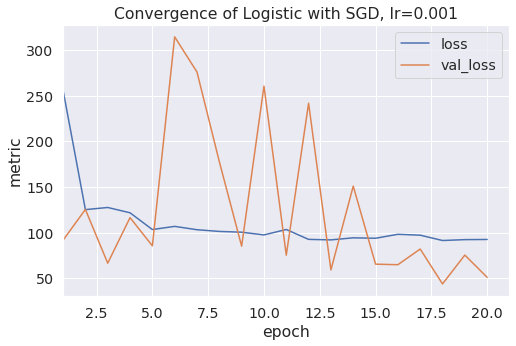

In [ ]:
lr.plot_history('loss')

We can observe big fluctuations, especially in the validation set. This is because the model is very shallow and in combination with a big learning rate (relative to the model), the loss impacts the results greatly during back propagation. The main issue resides in the fact that our pixels have not been normalized yet. This leads backpropagation to explode gradients and impact heavily the performance. Thus, as a next step we will normalize the dataset.

In [ ]:
X_train_st = min_max_scaling(X_train)
X_val_st = min_max_scaling(X_val)
X_test_st = min_max_scaling(X_test)

In [ ]:
#initiate the custom class
lr2 = MLP(
        SGD(learning_rate=1e-2)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name='Logistic with SGD, normalized input lr=0.01'
        ,model_id = 'h0_sgd_lr01_normalized_input'
        ,batch_norm=[False]
)

#fit the model
lr2.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=100
    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights and history for this model have been found: 0 to restore, 1 to refit0
Weights and history restored


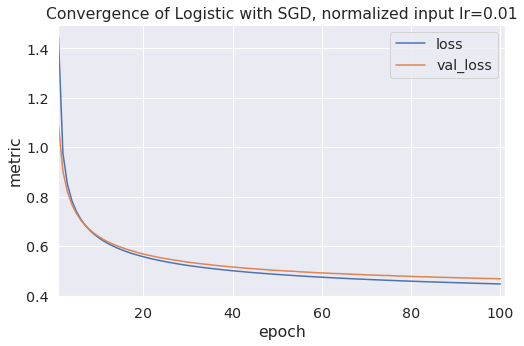

In [ ]:
lr2.plot_history('loss')

By standardizing the pixels, we were able to get a much more stable result, achieving lower losses. We can see that we could increase the number of epochs further, since the validation loss does not show any signs of increasing. However, since SGD seems to be making very small steps towards the end, it would be more beneficial to increase the learning rate.

In [ ]:
#initiate the custom class
lr3 = MLP(
        SGD(learning_rate=1e-1)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name = 'Logistic with SGD, lr=0.1'
        ,model_id = 'h0_sgd_lr1'
        ,batch_norm=[False]
)

#fit the model
lr3.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    )

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Best weights restored


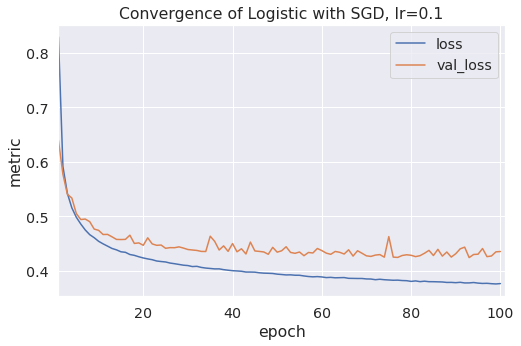

In [ ]:
lr3.plot_history('loss')

With an increase in learning rate `0.1` and using SGD, the model seems to plateau at around epoch 50

Next we will experiment with momentum, in order to see if we can manage a faster convergence

In [ ]:
#initiate the custom class
lr4 = MLP(
        SGD(learning_rate=1e-1, momentum = 0.5)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name = 'Logistic with SGD, lr=0.1, mom/um=0.5'
        ,model_id = 'h0_sgd_lr1_momentum5'
        ,batch_norm=[False]
)

#fit the model
lr4.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    )

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Best weights restored


Comparing the convergence of the two models, one with momentum and another without momentum we obtain:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


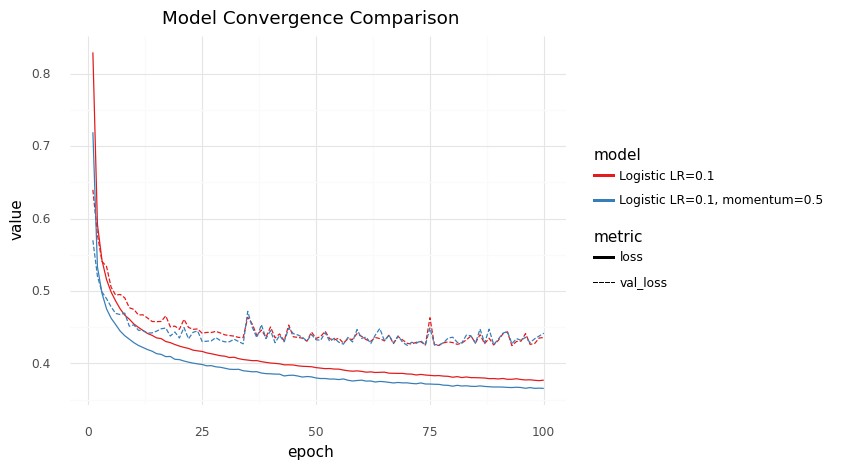

In [ ]:
plot_convergence_comparison(
    models = [lr3, lr4]
    ,model_names = ['Logistic LR=0.1', 'Logistic LR=0.1, momentum=0.5']
    ,metric = 'loss'
)

We observe that SGD with momentum has assisted the convergence in terms of speed, as well as it achieved lower values of loss, at least in the train and validation sets. We can check the performance on all sets for the two models, using the best weights of their history.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


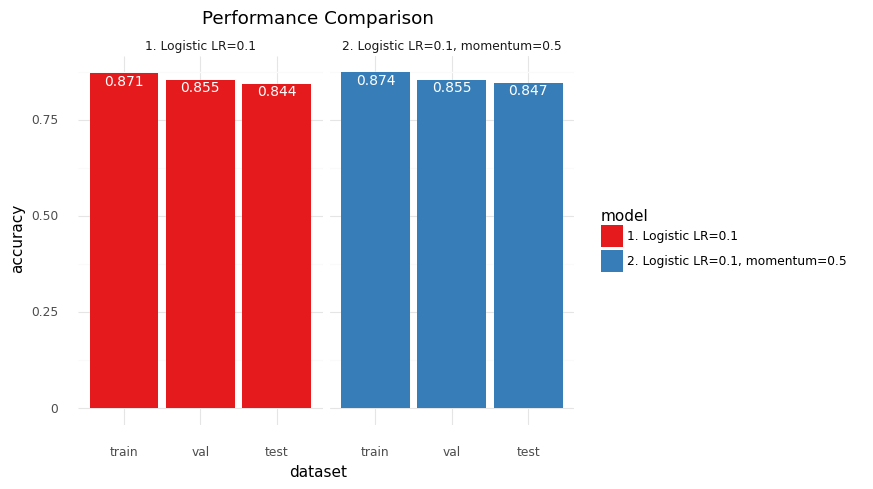

In [ ]:
plot_performance_comparison(
    models = [lr3, lr4]
    ,model_names = ['1. Logistic LR=0.1', '2. Logistic LR=0.1, momentum=0.5']
    ,metric = 'accuracy'
)

As one can observe, the scores of the shallow network are slightly better when using momentum. Additionally, there are no indications of overfitting, since the scores in the train/validation and test set are quite close for both models. This is natural, since we have a quite shallow model that does not have enough parameters to fit the noise.

Lastly, we will check the performance of the model using `Adam` as our optimizer.

In [ ]:
#initiate the custom class
lr5 = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name="Logistic with Adam, lr=0.001"
        ,model_id = "h0_adam_lr001"
        ,batch_norm=[False]
)

#fit the model
lr5.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    )

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights and history for this model have been found: 0 to restore, 1 to refit0
Weights and history restored


Plotting the convergence results we obtain:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


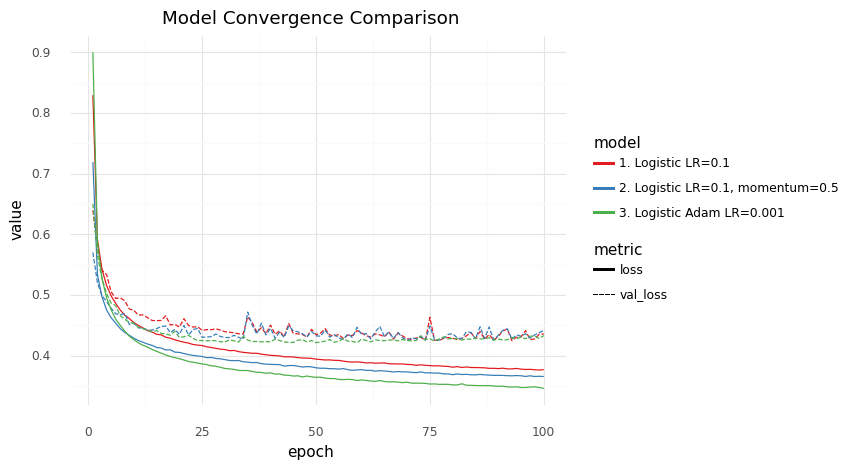

In [ ]:
plot_convergence_comparison(
    models = [lr3, lr4, lr5]
    ,model_names = ['1. Logistic LR=0.1', '2. Logistic LR=0.1, momentum=0.5', '3. Logistic Adam LR=0.001']
    ,metric = 'loss'
)

With the use of `Adam`, we managed to achieve a lower validation loss, as well as a faster convergence compared to a shallow Perceptron without momentum.

Let's compare the performance of Adam compared to SGD with and without momentum.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


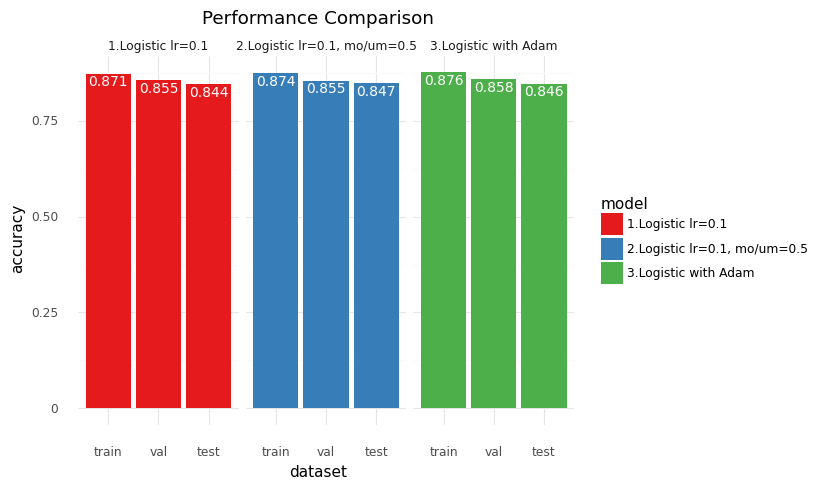

In [ ]:
plot_performance_comparison(
    models = [lr3, lr4, lr5]
    ,model_names = ['1.Logistic lr=0.1', '2.Logistic lr=0.1, mo/um=0.5', '3.Logistic with Adam']
    ,metric = 'accuracy'
)

All models achieve similar scores. What is important here, is that we do not observe indications of overfitting, since from the convergence comparison, as well as from the performance comparison plots, the performance of the models on the train, validation and tests sets are similar. This is natural to an extent, since our model is considered quite shallow for the task.

We will choose the model with the `Adam` optimizer as the best baseline, due to its faster convergence. As a next step, we will introduce the early-stopping callback, in order to reduce the training time as well restore the best weights during training.

In order to decide on the patience number, we can check how often a new minimum appears in the history of the fit.

In [ ]:
#get the validation loss from the history
lr5_val_loss = pd.DataFrame(lr5.hs.history['val_loss'], columns=['val_loss'])
#calculate the "cummulative" minimum
lr5_val_loss['running_min'] = lr5_val_loss.cummin()
#group by the cummulative minimum, in order to find for how many epochs it stayed as the minimum loss
freqs = lr5_val_loss.groupby('running_min').agg(minimum_loss_for_period = ('running_min', 'count')).reset_index()
freqs.sort_values(by='minimum_loss_for_period', ascending=False).head(10)

,running_min,minimum_loss_for_period
0,0.421137,42
3,0.422151,11
1,0.421286,9
2,0.421489,6
11,0.429673,3
4,0.422324,3
15,0.439099,2
7,0.424267,2
12,0.433573,2
21,0.459857,1


So even after 11 epochs, a new minimum loss was achieved during the fit. The rest of the values are `9` and `6`, apart from the outlier of `42`. Obvisously we will not wait for 42 epochs, thus, for start, we can set the `patience` to 15.

In [ ]:
#initiate the custom class
best_shallow = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = []
        ,hidden_activation = None
        ,dropouts = [0]
        ,output_activation='softmax'
        ,name="Logistic with Adam, lr=0.001"
        ,model_id = "best_shallow_adam_001"
        ,batch_norm=[False]
)

#fit the model
best_shallow.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,early_stop_patience=15
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
weights and history for this model have been found: 0 to restore, 1 to refit0
Weights and history restored


The history is:

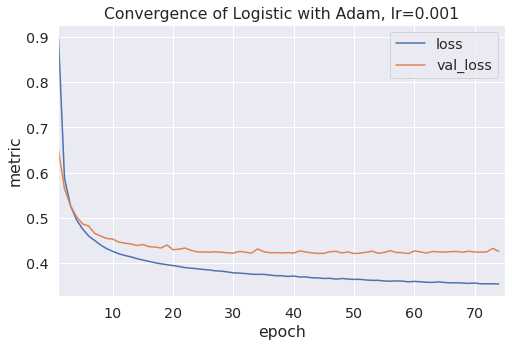

In [ ]:
best_shallow.plot_history('loss')

The performance is:

In [ ]:
best_shallow.evaluate(X_train_st, y_train, X_val_st, y_val, X_test_st, y_test)

,set,accuracy,precision,recall,f1
0,train,0.875833,0.877725,0.875833,0.876486
1,val,0.857500,0.859197,0.857500,0.858124
2,test,0.846500,0.849165,0.846500,0.847369


### Error Analysis



Having settled on a good baseline model, we will have a look at the incorrectly classified instances.

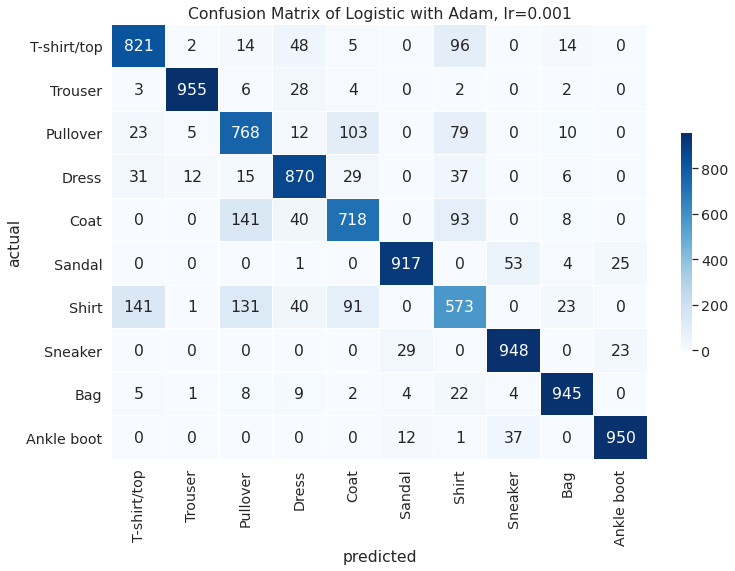

Plotting examples of misclassified objects


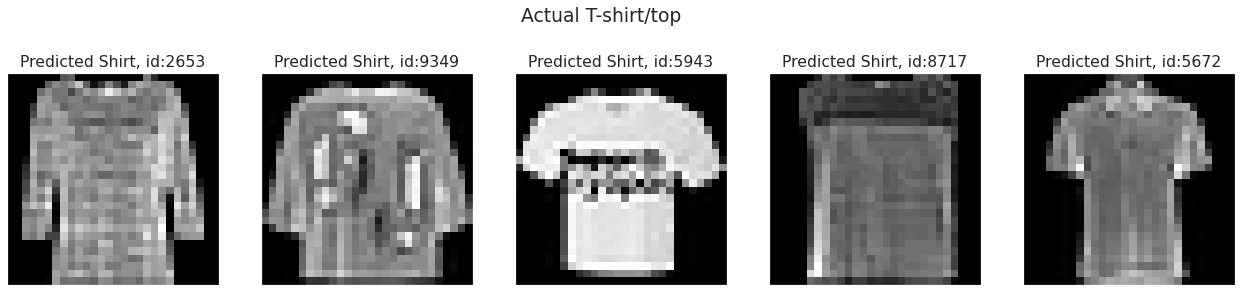

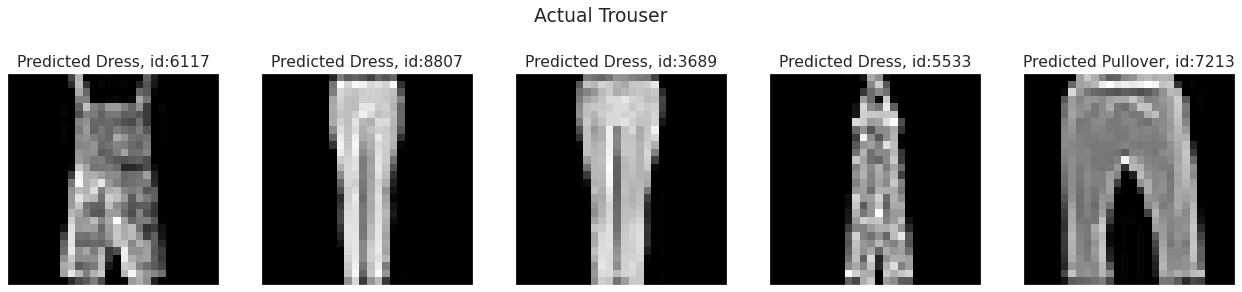

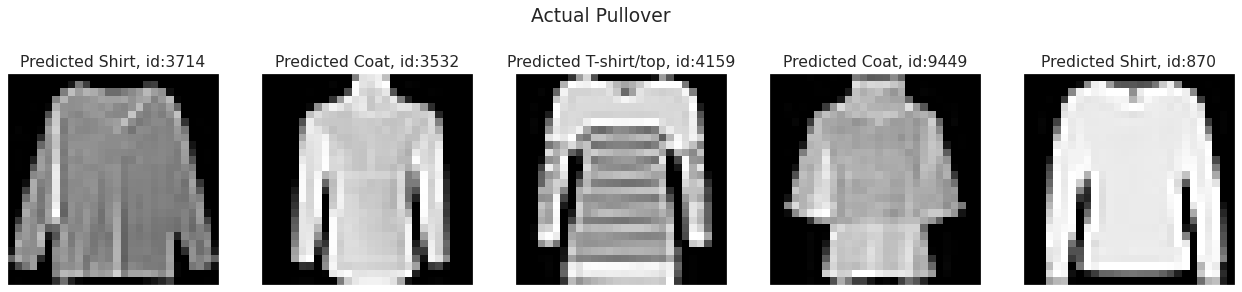

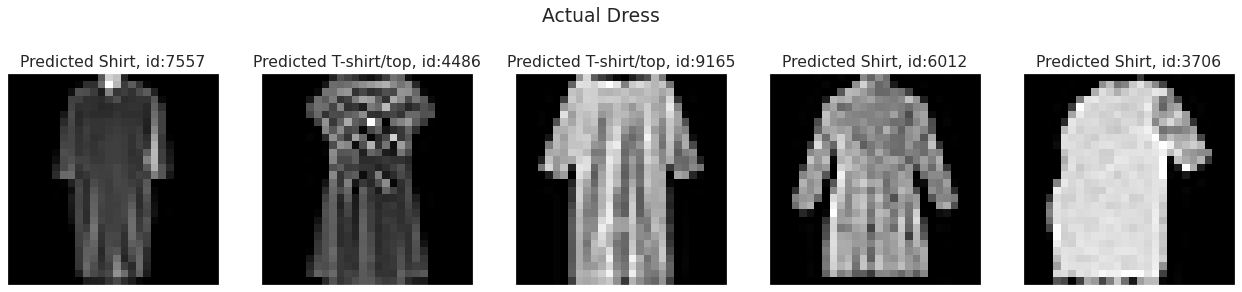

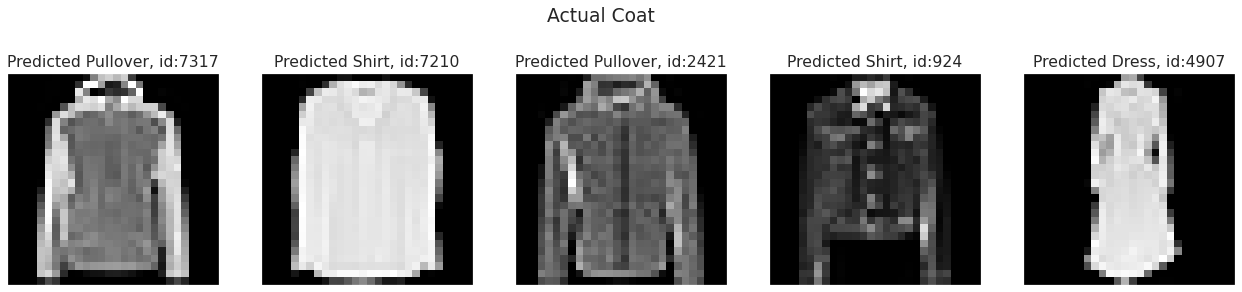

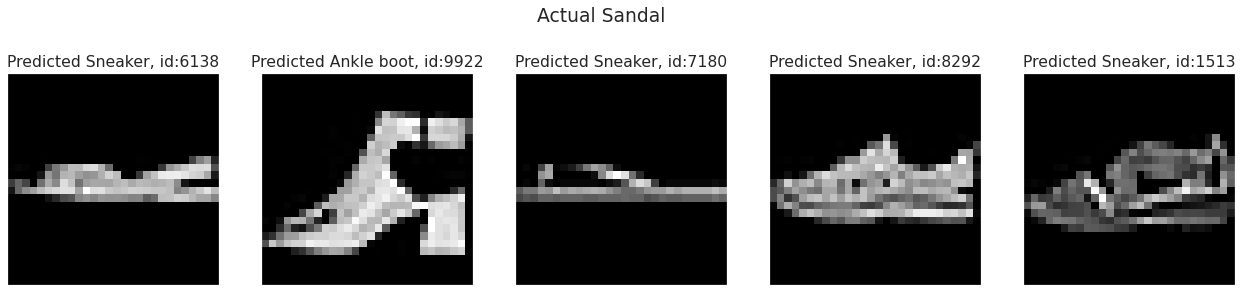

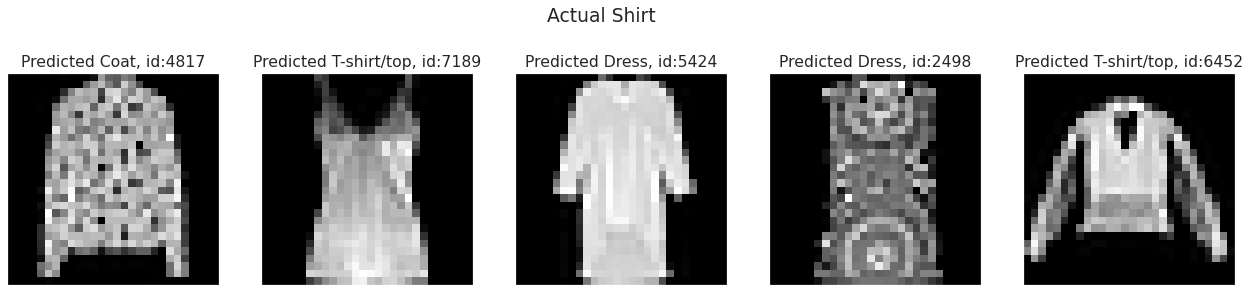

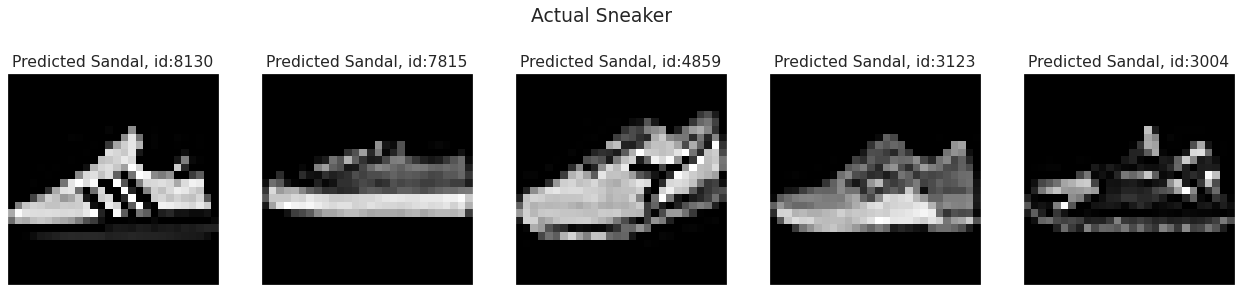

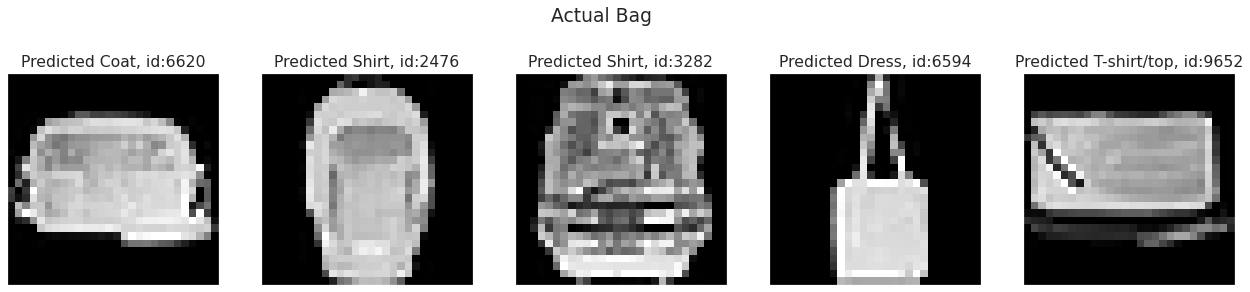

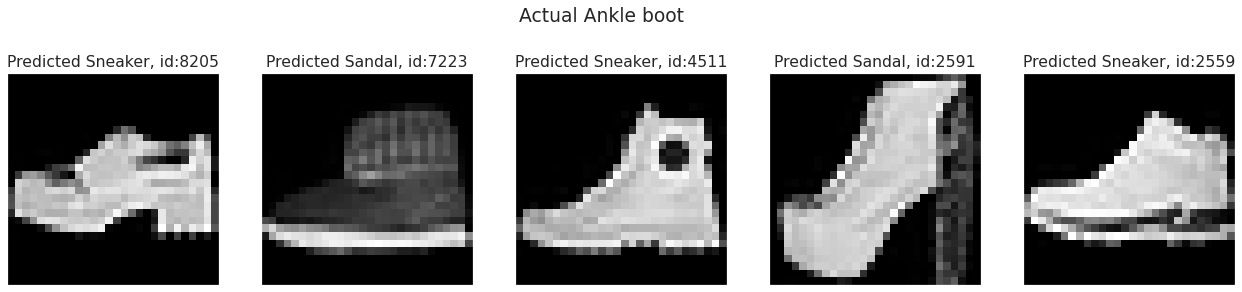

In [ ]:
df_errors = best_shallow.error_analysis(X_test_st, y_test, plot_errors=True)

Observations:

* Many `shirts` are classified as `T-shirts`, `Coats` or `Pullovers`. From the sample misclassified objects, we observe shirts with irregular shapes and sizes
* Many `sandals` are classified as `sneakers` or `ankle boots`. From the samples we observe many sandals which star from a much higher point of the foot, thus the model might naively classify them as ankle boots
* Many `pullovers` are classified as `coats`.
* Many `sneakers` are classified as `ankle boots`. From the misclassified samples, we can observe that many sneakers start from the ankle point of the foot. As a result, the model naively classifies them as ankle boots.

Ideally, most of the above errors might be solved by adding complexity to the model. In the next section we will continue experimenting with Perceptrons, but this time using hidden layers.

## 1 Hidden Layer

We will start with adding one hidden layer, and we will experiment with different activation functions. At the beginning we will not use any early patience, in order to understand the landscape of the parameter space.

In [ ]:
#initiate the custom class
mlp1_sig = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512]
        ,hidden_activation = 'sigmoid'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 sigmnoid'
        ,model_id = 'h1_adam_sigmoid'
        ,batch_norm=[False]
)

#fit the model
mlp1_sig.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
____________________________________________________

In [ ]:
#initiate the custom class
mlp1_tanh = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512]
        ,hidden_activation = 'tanh'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 tanh'
        ,model_id = 'h1_adam_tanh'
        ,batch_norm=[False]
)

#fit the model
mlp1_tanh.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
____________________________________________________

In [ ]:
#initiate the custom class
mlp1_relu = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 relu'
        ,model_id = 'h1_adam_relu'
        ,batch_norm=[False]
)

#fit the model
mlp1_relu.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


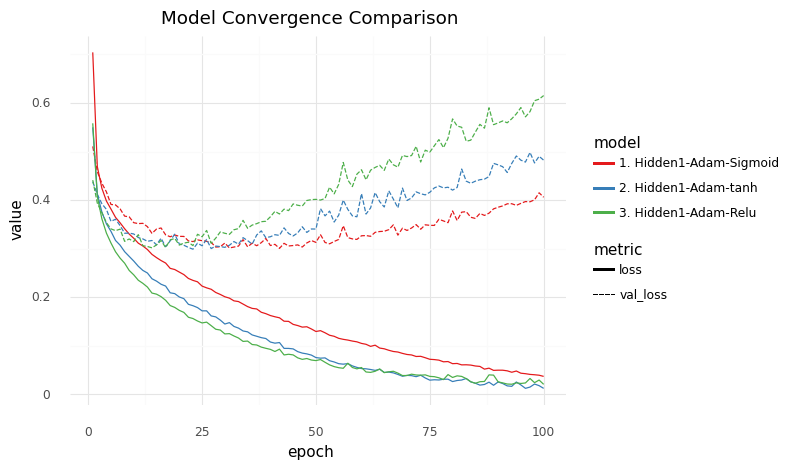

In [ ]:
plot_convergence_comparison(
    models = [mlp1_sig, mlp1_tanh, mlp1_relu]
    ,model_names = ['1. Hidden1-Adam-Sigmoid', '2. Hidden1-Adam-tanh', '3. Hidden1-Adam-Relu']
    ,metric = 'loss'
)

From the convergence plot, we can observe that `ReLU` converges slightly faster than the `tanh` but surely faster than the `sigmoid`. The `sigmoid` function, having only positive values and squishing them to [0,1] tends to converge slower, since the derivatives will be more saturated towards the tails of the function. Additionally, since the outputs are positive, the weights attached to a node will be updated only to a positive or negative direction, during back propagation. On the other hand `tanh` contains negative values and is centered around 0, thus producing gradients of higher magnitude and with different signs.

One last thing that we observe from the convergence plot, is that our learning rate could be considered high, since in less than 20 epochs we reached the best local minimum using `tanh` and `ReLU`.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


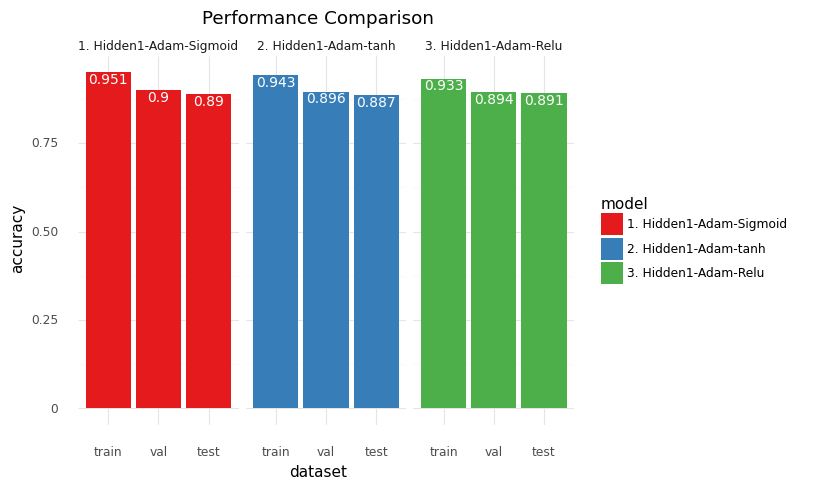

In [ ]:
plot_performance_comparison(
    models = [mlp1_sig, mlp1_tanh, mlp1_relu]
    ,model_names = ['1. Hidden1-Adam-Sigmoid', '2. Hidden1-Adam-tanh', '3. Hidden1-Adam-Relu']
    ,metric = 'accuracy'
)

Using the best weights of each model, we observe a similar performance, with ReLU being slightly more accurate. However, there are are bigger deviations between the performances on the train and the test set. As a result, we could consider adding some regularization in the form of dropout, or batch normalization.

In our next attempt, we will keep `ReLU` as our activation function. In order to improve the performance we will experiment with the following techniques:

* Addition of dropout rate
* Reduction of the learning rate

Next is the model with the dropout rate.

In [ ]:
#initiate the custom class
mlp1_relu_dr = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.3]
        ,output_activation='softmax'
        ,name = 'Hidden1 relu'
        ,model_id = 'h1_adam_relu_dr3'
        ,batch_norm = [False]
)

#fit the model
mlp1_relu_dr.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=50
    ,verbose=0
    )

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
____________________________________________________

Next is the model with the reduced learning rate.

In [ ]:
#initiate the custom class
mlp1_relu_low_lr = MLP(
        Adam(learning_rate=1e-4)
        ,hidden_layers = [512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 relu'
        ,model_id = 'h1_adam_relu_lr0001'
        ,batch_norm = [False]
)

#fit the model
mlp1_relu_low_lr.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


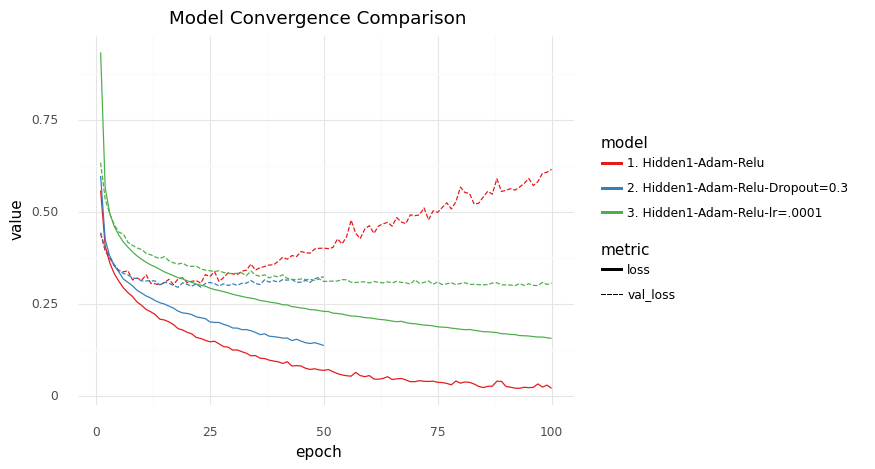

In [ ]:
plot_convergence_comparison(
    models = [mlp1_relu, mlp1_relu_dr, mlp1_relu_low_lr]
    ,model_names = ['1. Hidden1-Adam-Relu', '2. Hidden1-Adam-Relu-Dropout=0.3', '3. Hidden1-Adam-Relu-lr=.0001']
    ,metric = 'loss'
)

Observations from the convergence plot:

* The addition of dropout rate, did not seem to achieve a better performance on the validation data.
* Lowering the learning rate did not achieve a better local minimum. 

The performance of the models on all sets is the following:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


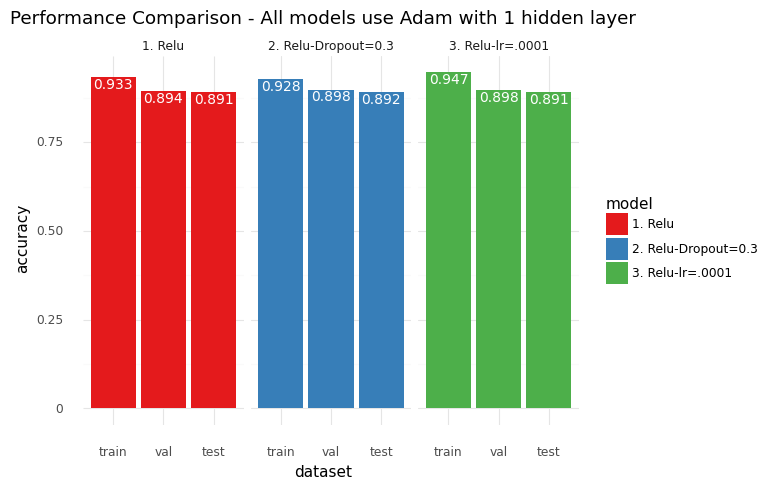

In [ ]:
plot_performance_comparison(
    models = [mlp1_relu, mlp1_relu_dr, mlp1_relu_low_lr]
    ,model_names = ['1. Relu', '2. Relu-Dropout=0.3', '3. Relu-lr=.0001']
    ,metric = 'accuracy'
    ,caption = ' - All models use Adam with 1 hidden layer'
)

We achieved a small uplift using dropout as well as using a lower learning rate. However, from the convergence plot it is obvious that the model with the dropout converges much faster. 

Keeping the dropout model as our best model so far, we will experiment with reducing the units of the hidden layer.

In [ ]:
#initiate the custom class
mlp1_relu_reduced_units_256 = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [256]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 relu'
        ,model_id = 'h1_256_adam_relu'
        ,batch_norm = [False]
)

#fit the model
mlp1_relu_reduced_units_256.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
____________________________________________________

In [ ]:
#initiate the custom class
mlp1_relu_reduced_units_128 = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [128]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0]
        ,output_activation='softmax'
        ,name = 'Hidden1 relu'
        ,model_id = 'h1_128_adam_relu'
        ,batch_norm = [False]
)

#fit the model
mlp1_relu_reduced_units_128.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
____________________________________________________

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


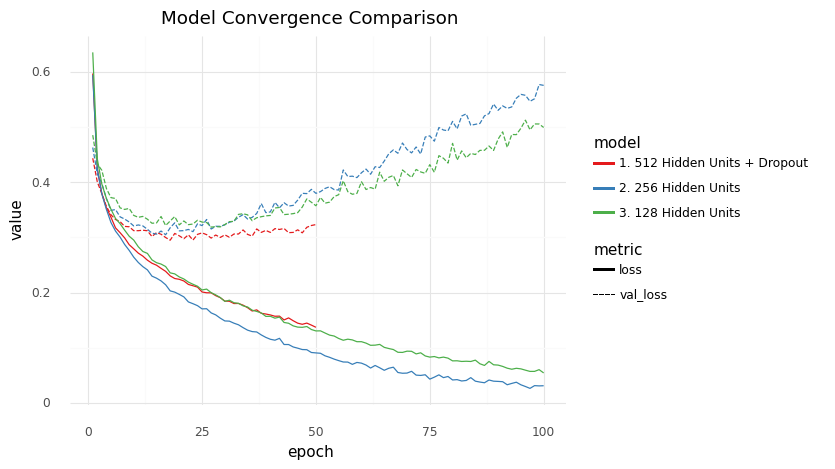

In [ ]:
plot_convergence_comparison(
    models = [mlp1_relu_dr, mlp1_relu_reduced_units_256, mlp1_relu_reduced_units_128]
    ,model_names = ['1. 512 Hidden Units + Dropout', '2. 256 Hidden Units', '3. 128 Hidden Units']
    ,metric = 'loss'
)

From the convergence plot, we observe that the model with `128` units is not able to achieve the same performance as the models with `256` and `512` units.
The last two dimensions can be used as the limits of the hyper-parameter space during the hypertuning process.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


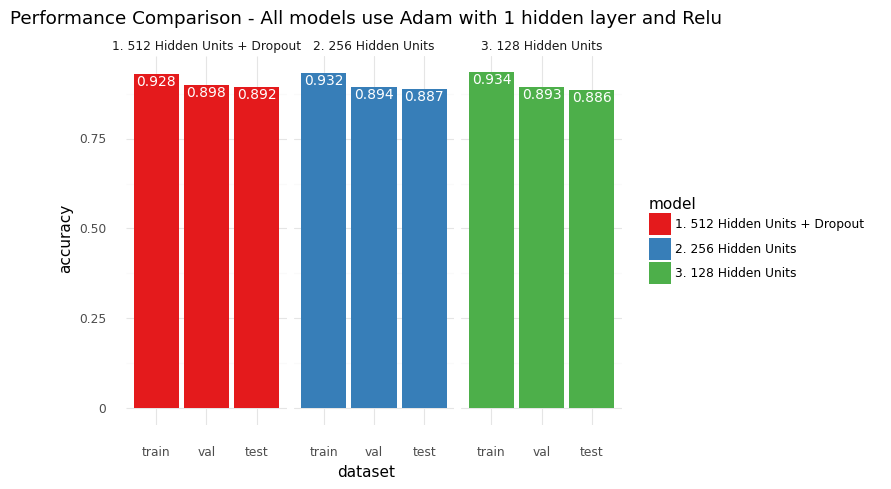

In [ ]:
plot_performance_comparison(
    models = [mlp1_relu_dr, mlp1_relu_reduced_units_256, mlp1_relu_reduced_units_128]
    ,model_names = ['1. 512 Hidden Units + Dropout', '2. 256 Hidden Units', '3. 128 Hidden Units']
    ,metric = 'accuracy'
    ,caption = ' - All models use Adam with 1 hidden layer and Relu'
)

From the pefrormance of the models, we can observe that the best model so far is the one with `512` units in the hidden layer which uses a dropout layer on top. Next we will try to gain some info on the patience hyperparameter of the Early Stopping.

In [ ]:
#get the validation loss from the history
mlp1_relu_dr_loss = pd.DataFrame(mlp1_relu_dr.hs.history['val_loss'], columns=['val_loss'])
#calculate the "cummulative" minimum
mlp1_relu_dr_loss['running_min'] = mlp1_relu_dr_loss.cummin()
#group by the cummulative minimum, in order to find for how many epochs it stayed as the minimum loss
freqs = mlp1_relu_dr_loss.groupby('running_min').agg(minimum_loss_for_period = ('running_min', 'count')).reset_index()
freqs.sort_values(by='minimum_loss_for_period', ascending=False).head(10)

,running_min,minimum_loss_for_period
0,0.294961,33
2,0.301524,3
4,0.312216,2
1,0.299837,1
3,0.312048,1
5,0.312258,1
6,0.319327,1
7,0.319999,1
8,0.328700,1
9,0.332527,1


We can see that the best local minimum was achieved after a patience of 3 epochs. We can use 5 epochs as the patience for early stopping.

In [ ]:
#initiate the custom class
best_hidden_1 = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.3]
        ,output_activation='softmax'
        ,name = 'One Hidden Layer[512] with dropout'
        ,model_id = 'best_hidden_512_dropout3'
        ,batch_norm = [False]
)

#fit the model
best_hidden_1.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=50
    ,verbose=0
    ,early_stop_patience=5
    )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_____________________________________________________

The performance of the best model with one hidden layer is.

In [ ]:
best_hidden_1.evaluate(X_train_st, y_train, X_val_st, y_val, X_test_st, y_test)

,set,accuracy,precision,recall,f1
0,train,0.93475,0.936310,0.93475,0.934946
1,val,0.89925,0.900827,0.89925,0.899495
2,test,0.89230,0.894759,0.89230,0.892482


### Error Analysis

Having a good performing model with one hidden layer, we can proceed with the error analysis.

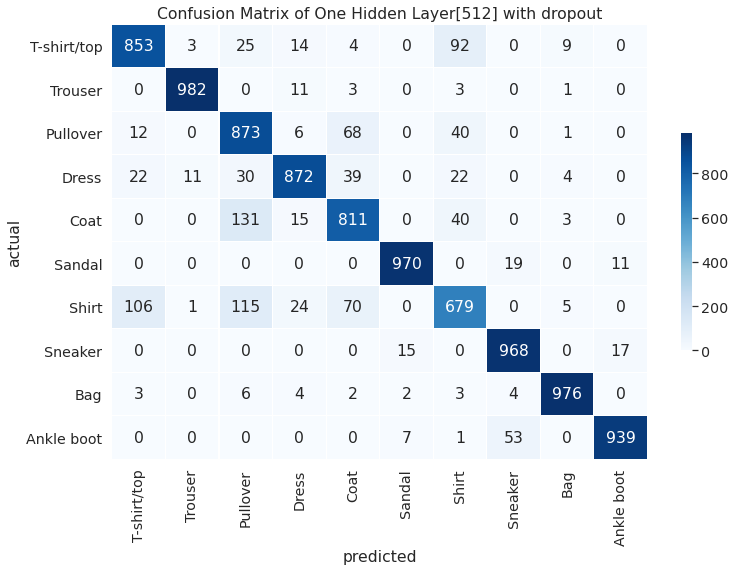

Plotting examples of misclassified objects


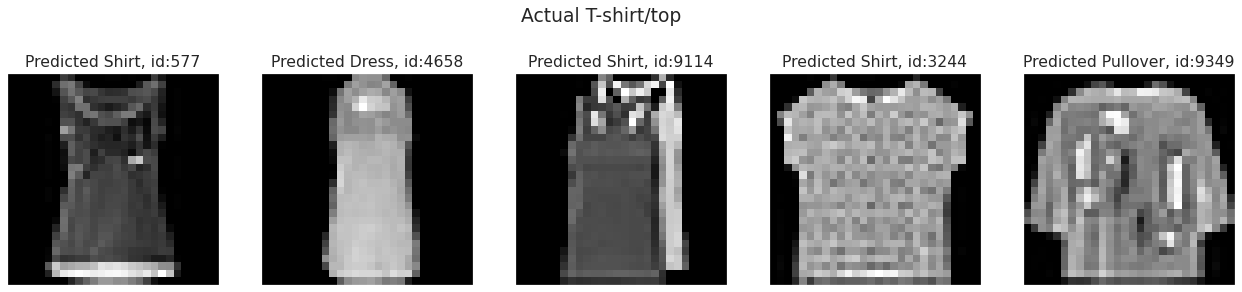

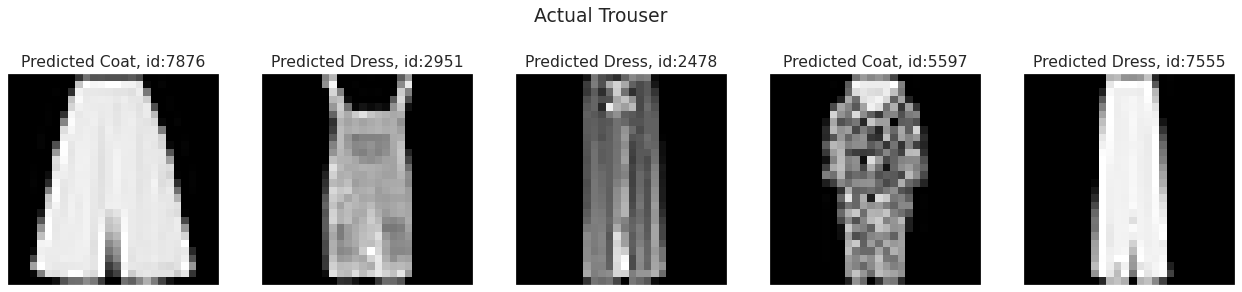

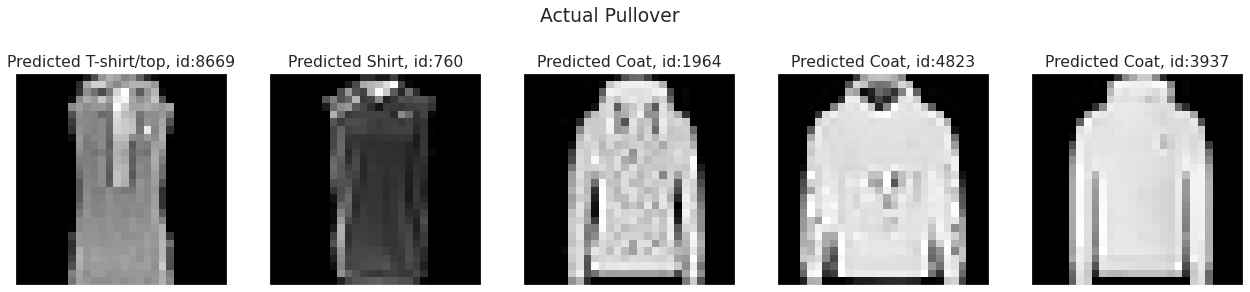

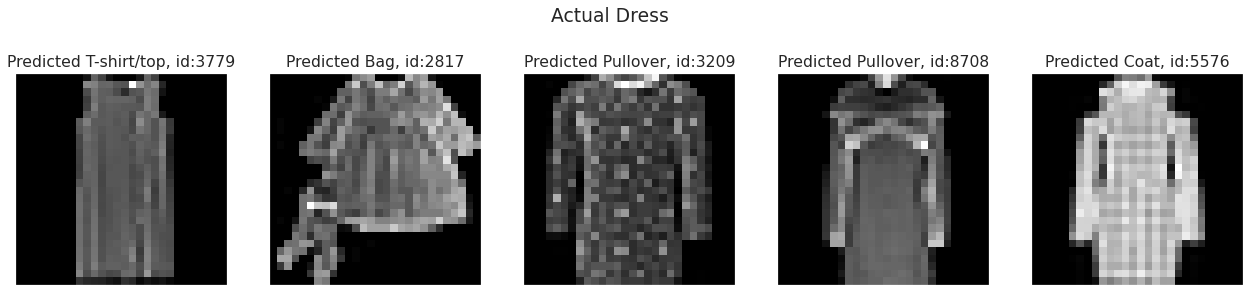

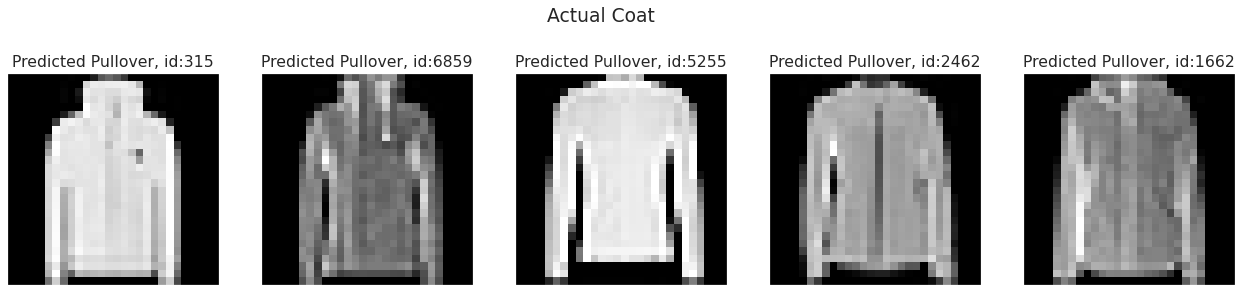

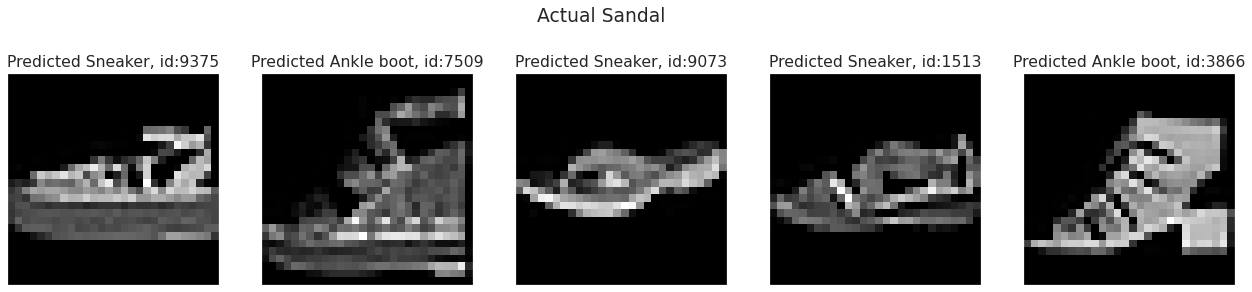

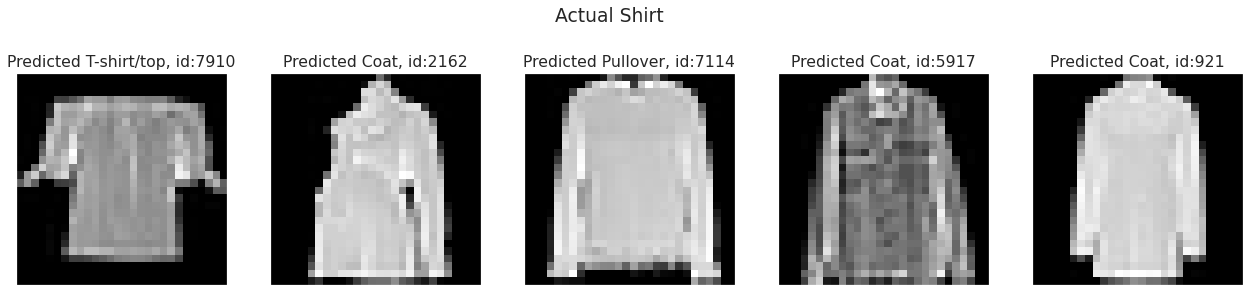

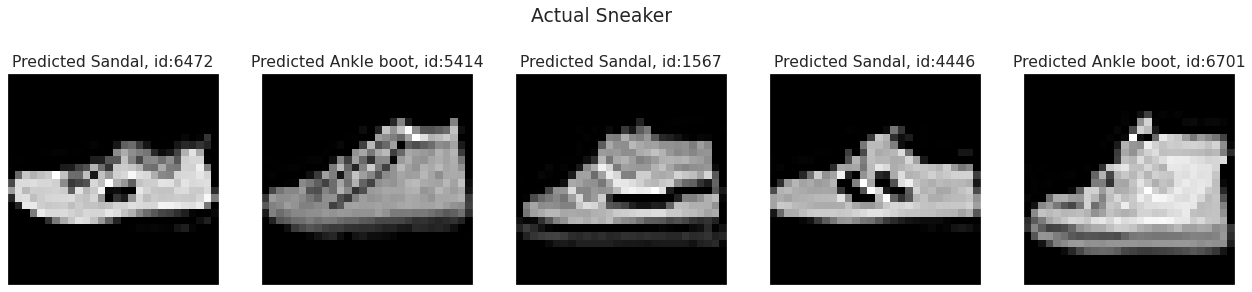

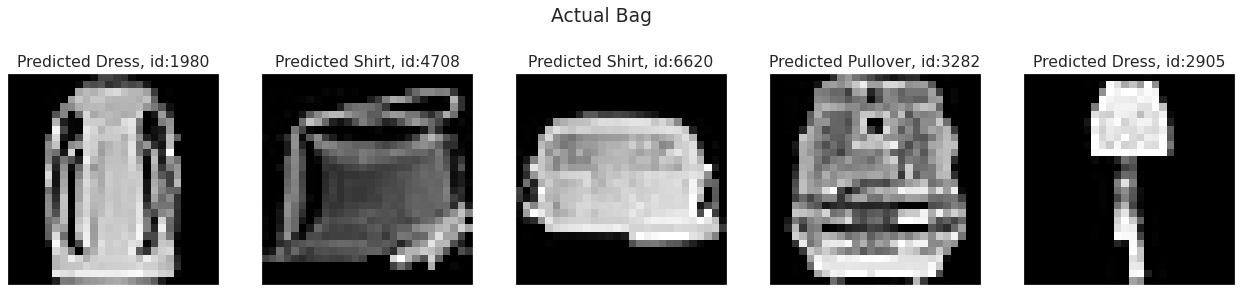

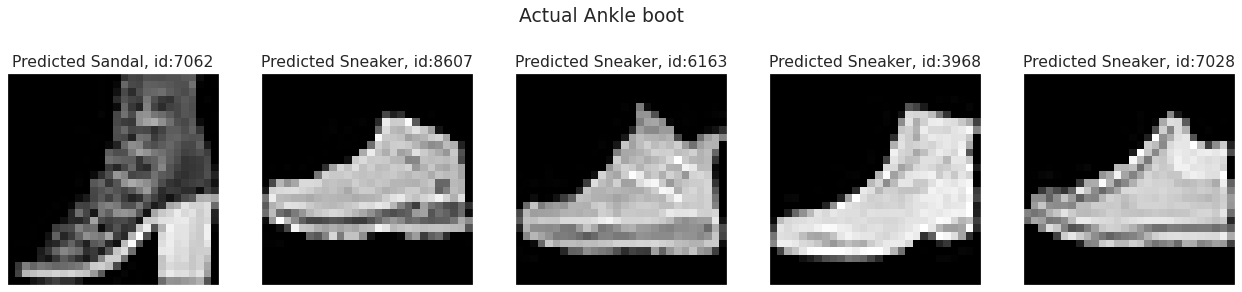

In [ ]:
df_errors = best_hidden_1.error_analysis(X_test_st, y_test, plot_errors=True)

Observations:

* There are still many `actual` `shirts` which are missclassified. Although the number of correctly classified shirts has increased from `573` to `679` when compared with the `best shallow model` 
* There are still many `actual` `pullovers` which are missclassified. Although the number of correctly classified pullovers has increased from `768` to `873` when compared with the `best shallow model` 

## More Hidden Layers

We will experiment with the addition of more hidden layers. We will fit the following two models:

* 2 hidden layers [512, 256] with learning rate 0.001 without dropout
* 2 hidden layers [1024, 512] with dropout, lowering the learning rate to `0.0001` since we increased the complexity. 

In [ ]:
 #initiate the custom class
mlp2 = MLP(
        Adam(learning_rate=1e-3)
        ,hidden_layers = [512, 256]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0,0]
        ,output_activation='softmax'
        ,name = '2 Hidden layers'
        ,model_id = 'h2_adam_relu'
        ,batch_norm=[False, False]
)

#fit the model
mlp2.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=50
    ,verbose=0
    )

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0  

In [ ]:
 #initiate the custom class
mlp2_dr = MLP(
        Adam(learning_rate=1e-4)
        ,hidden_layers = [1024, 512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.3,0.5]
        ,output_activation='softmax'
        ,name = '2 Hidden layers'
        ,model_id = 'h2_adam_relu_dr33_lr0001'
        ,batch_norm=[False, False]
)

#fit the model
mlp2_dr.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=100
    ,verbose=0
    )

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 2028)              1591980   
_________________________________________________________________
activation_1 (Activation)    (None, 2028)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2028)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               1038848   
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0  

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


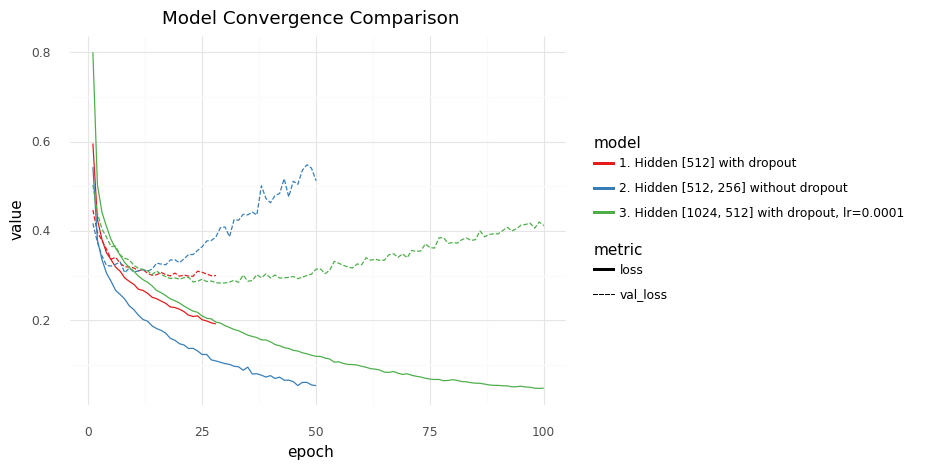

In [ ]:
plot_convergence_comparison(
    models = [best_hidden_1, mlp2, mlp2_dr]
    ,model_names = ['1. Hidden [512] with dropout', '2. Hidden [512, 256] without dropout', '3. Hidden [1024, 512] with dropout, lr=0.0001']
    ,metric = 'loss'
)

Observations:

* The model with the 2 hidden layers [512, 256] without dropout, have the same performance as the best model with only 1 hidden layer. It also overfits much quicker.
* The model with the 2 hidden layers [1024, 512] and with dropout has achieved a lower validation score than the other 2. The increase in units, in combination with the decrease in the learning rate managed to avoid overfitting.

The performance of the models is:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


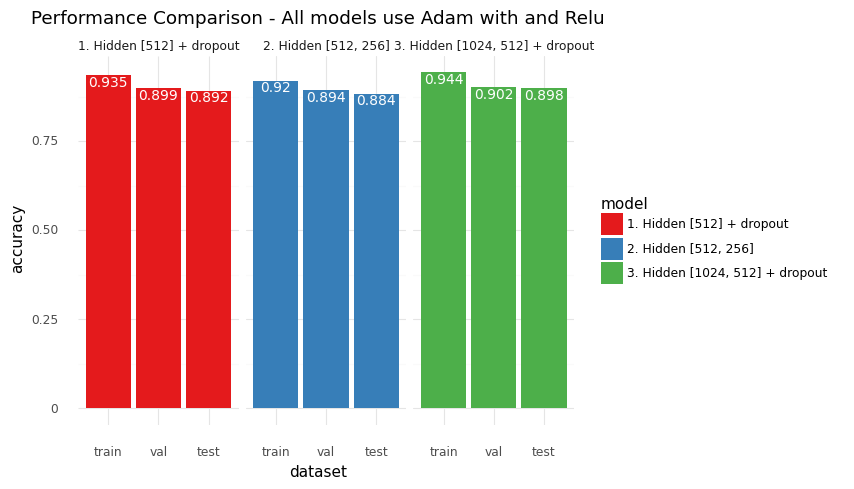

In [ ]:
plot_performance_comparison(
    models = [best_hidden_1, mlp2, mlp2_dr]
    ,model_names = ['1. Hidden [512] + dropout', '2. Hidden [512, 256]', '3. Hidden [1024, 512] + dropout']
    ,metric = 'accuracy'
    ,caption = ' - All models use Adam with and Relu'
)

By using 2 layers with a high number of units, we managed to increase the accuracy on the test set from `0.892` which was our best model with a single hidden layer to `0.898`. The trick here was to use a smaller learning rate, since by adding more capacity to the model, it is more prone to overfit. Such a model operates in a higher dimensional space, and using high learning rates can diverge the weights to meaningless locations.

We will also experiment with Batch-Normalization at this point, in case we improve further the performance. We deliberately increase the batch size to `512`, in order to acquire more stable means and standard deviations during the normalization step. Additionally we reduced the dropout rates, since batch normalization is already a form of regularization.

In [ ]:
 #initiate the custom class
mlp2_bn = MLP(
        Adam(learning_rate=1e-4)
        ,hidden_layers = [1024, 512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.1,0.1]
        ,output_activation='softmax'
        ,name = '2 Hidden layers'
        ,model_id = 'h2_adam_relu_dr35_lr0001_bn'
        ,batch_norm=[True, True]
)

#fit the model
mlp2_bn.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 512
    ,epochs=100
    ,verbose=0
    )

Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 1024)              803840    
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               524

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


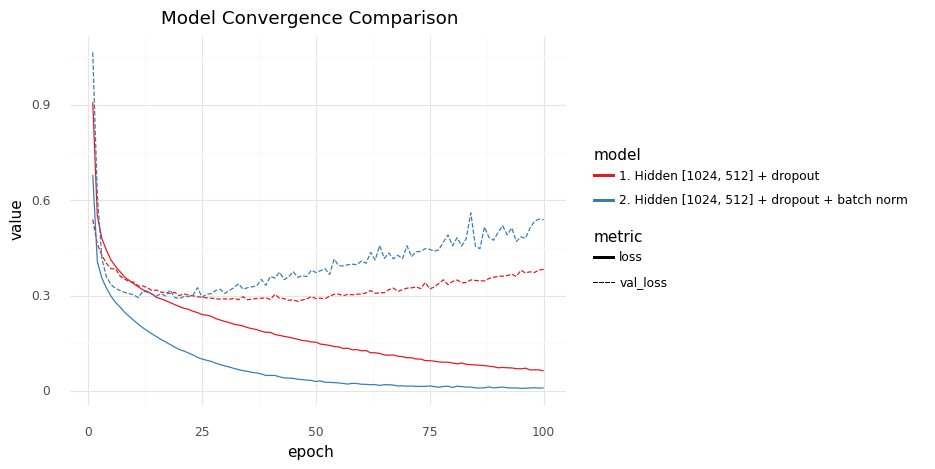

In [ ]:
plot_convergence_comparison(
    models = [mlp2_dr, mlp2_bn]
    ,model_names = ['1. Hidden [1024, 512] + dropout', '2. Hidden [1024, 512] + dropout + batch norm']
    ,metric = 'loss'
)

In terms of convergence, batch normalization indeed converged faster. Let's look at the performance.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


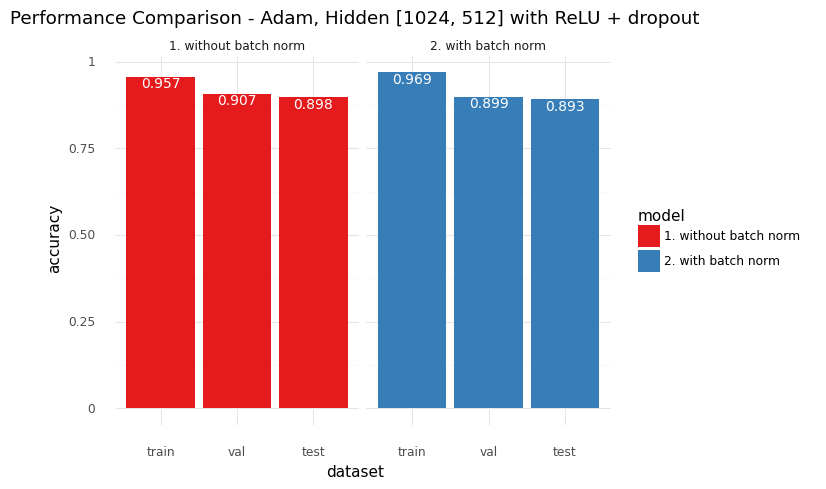

In [ ]:
plot_performance_comparison(
    models = [mlp2_dr, mlp2_bn]
    ,model_names = ['1. without batch norm', '2. with batch norm']
    ,metric = 'accuracy'
    ,caption = ' - Adam, Hidden [1024, 512] with ReLU + dropout'
)

Batch norm did not generalize well on the test sets. Thus we will not consider it during the hypertuning. Thus the best model that we achieved so far, has the following architecture:

* 2 hidden units [1024, 512] with ReLU
* dropout after each unit
* Adam as the optimizer

Let's look at the history of the model in order to understand more the landscape of the cost function. This will help us to obtain a good value for the patience parameter of Early Stopping.

In [ ]:
#get the validation loss from the history
mlp2_dr_loss = pd.DataFrame(mlp2_dr.hs.history['val_loss'], columns=['val_loss'])
#calculate the "cummulative" minimum
mlp2_dr_loss['running_min'] = mlp2_dr_loss.cummin()
#group by the cummulative minimum, in order to find for how many epochs it stayed as the minimum loss
freqs = mlp2_dr_loss.groupby('running_min').agg(minimum_loss_for_period = ('running_min', 'count')).reset_index()
freqs.sort_values(by='minimum_loss_for_period', ascending=False).head(10)

,running_min,minimum_loss_for_period
0,0.281963,55
2,0.286993,9
12,0.299885,3
17,0.330092,2
15,0.316078,2
1,0.285243,2
13,0.306161,2
14,0.310388,2
5,0.288733,2
4,0.288386,2


We can see that the best minimum was achieved with a patience of 9 epochs. We can use the number `12` as our patience parameter for Early Stopping.

In [ ]:
#initiate the custom class
best_deep_mlp = MLP(
        Adam(learning_rate=1e-4)
        ,hidden_layers = [1024, 512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.3,0.5]
        ,output_activation='softmax'
        ,name = '2 Hidden layers [1025, 512] + dropout'
        ,model_id = 'h2_adam_relu_dr33_lr0001'
        ,batch_norm=[False, False]
)

#fit the model
best_deep_mlp.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot
    ,batch_size= 256
    ,epochs=150
    ,verbose=0
    ,early_stop_patience=50
    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 1024)              803840    
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0   

The performance of the model is:

In [ ]:
best_deep_mlp.evaluate(X_train_st, y_train, X_val_st, y_val, X_test_st, y_test)

,set,accuracy,precision,recall,f1
0,train,0.956688,0.957489,0.956688,0.956847
1,val,0.907250,0.908644,0.907250,0.907635
2,test,0.897800,0.899446,0.897800,0.898234


### Error Analysis

Having a good performing model with 2 hidden layers, we can proceed with the error analysis.

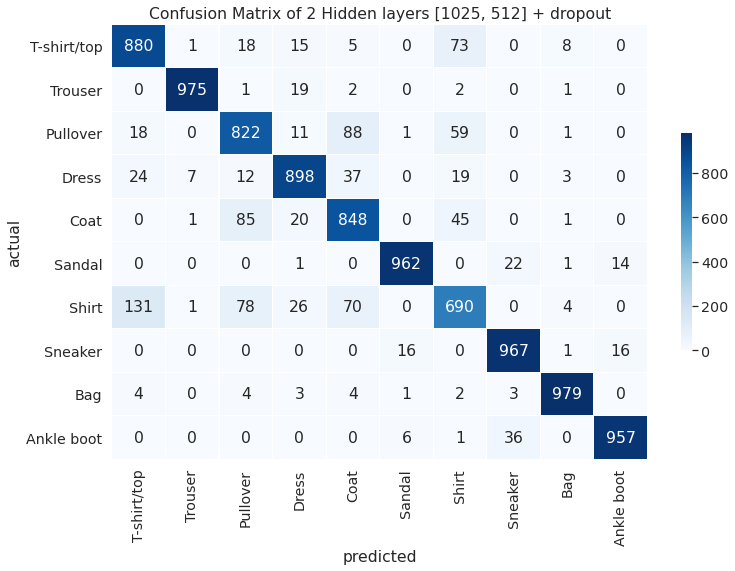

Plotting examples of misclassified objects


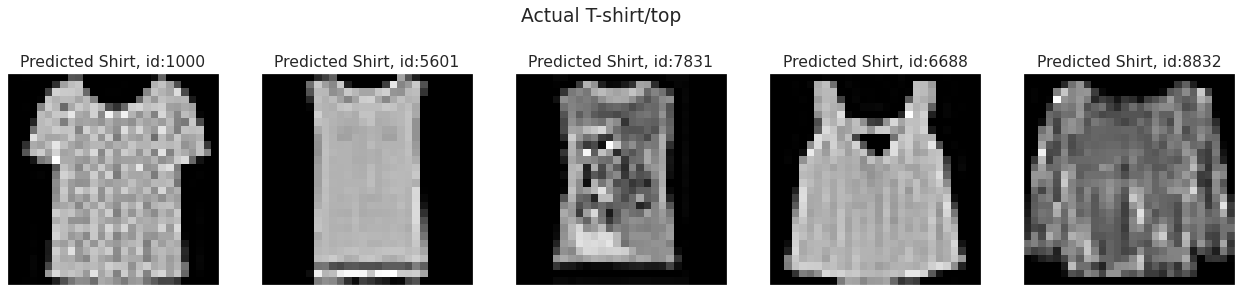

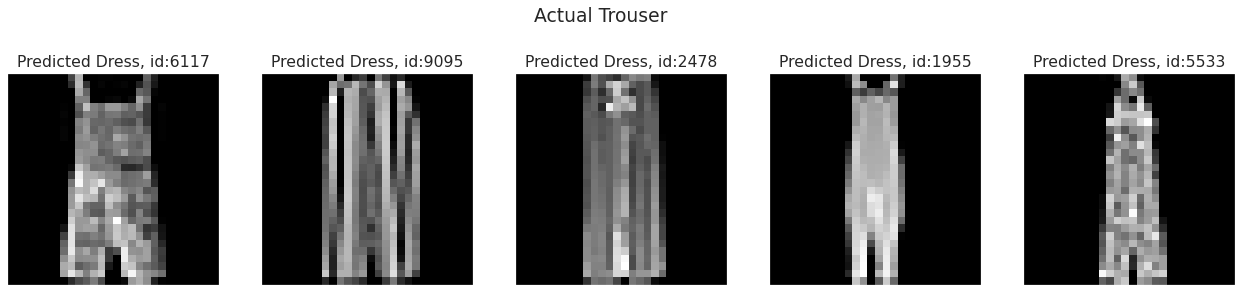

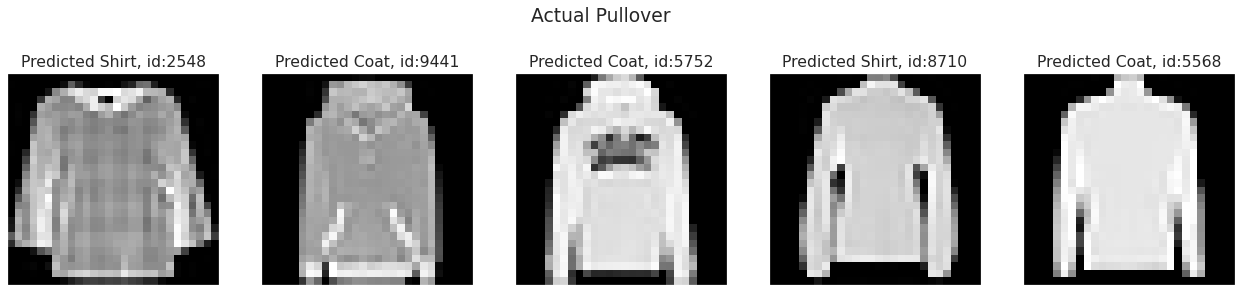

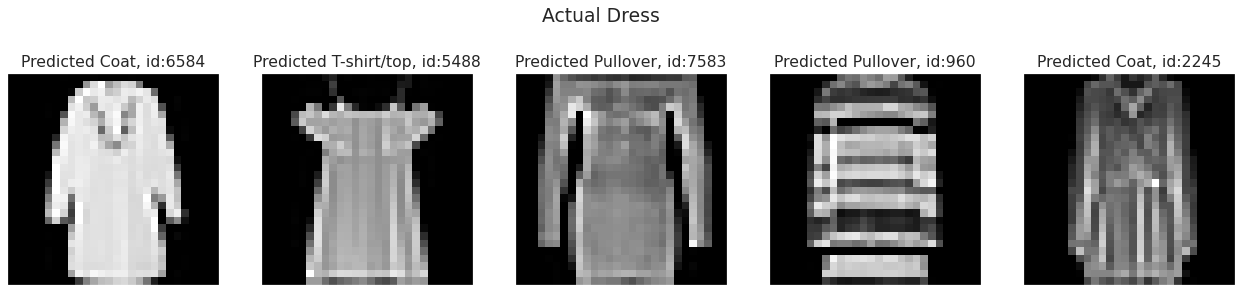

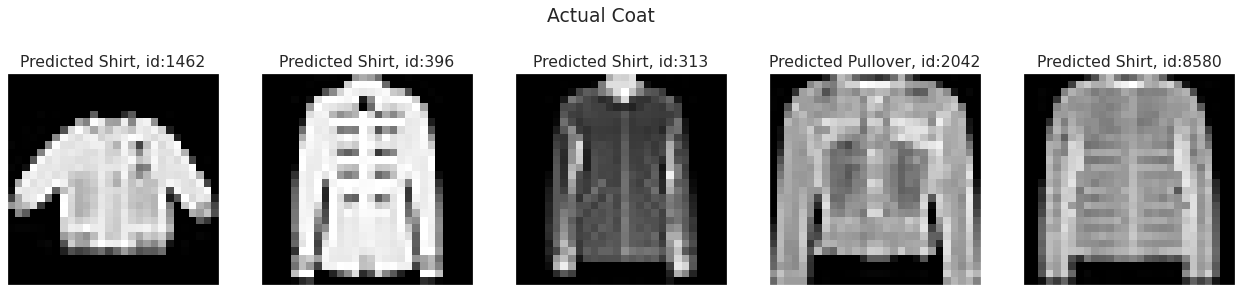

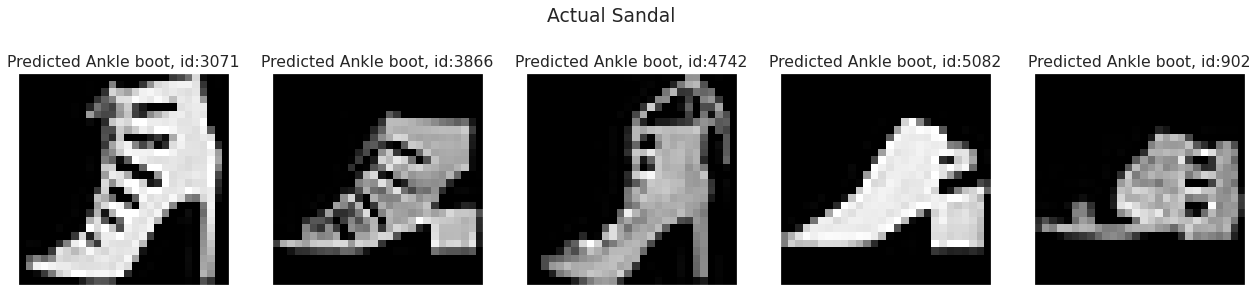

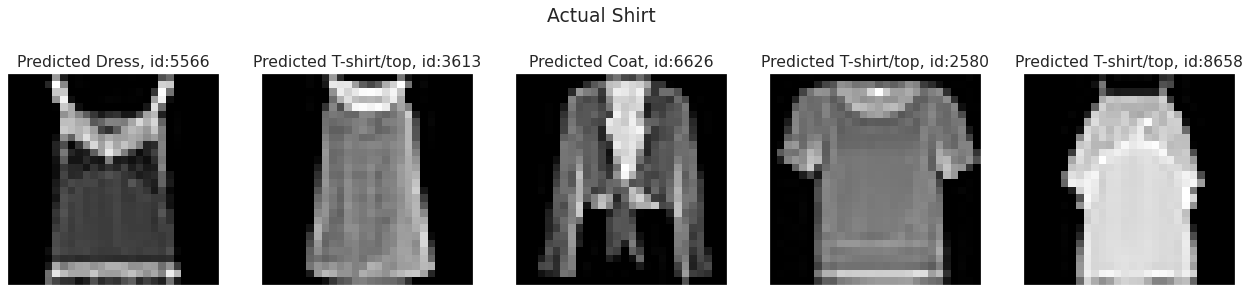

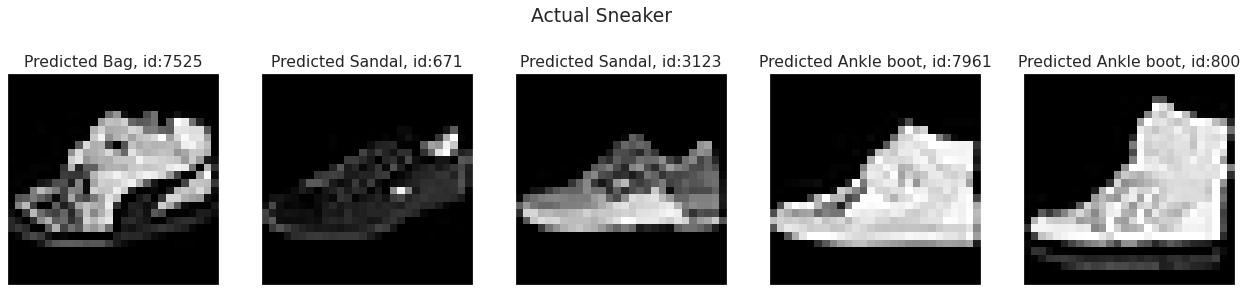

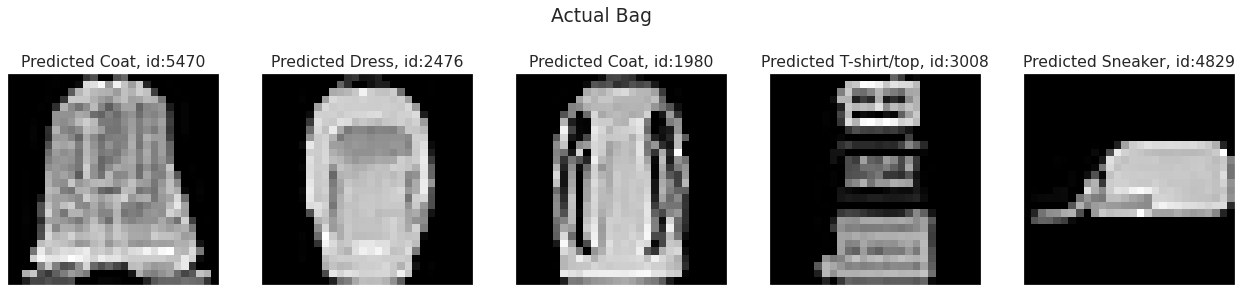

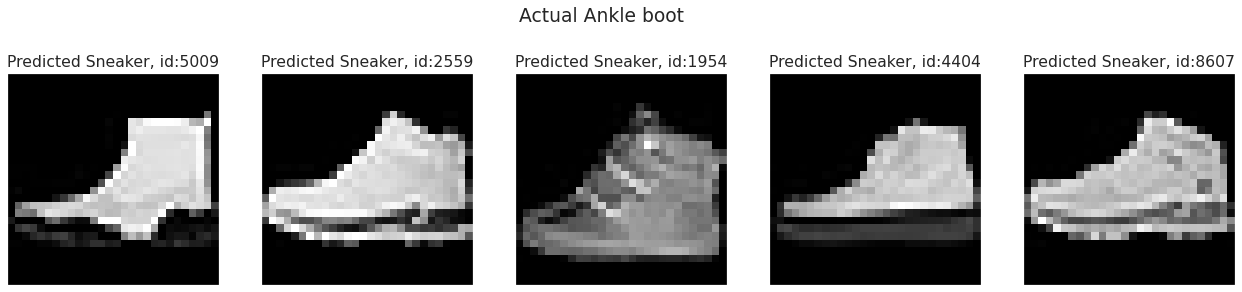

In [ ]:
df_error = best_deep_mlp.error_analysis(X_test_st, y_test, plot_errors=True)

Observations:

* In the shirts category, we observe a shift in the missclassified objects, since actual `shirts` are missclassified mostly as `T-shirts` and not as `pullovers`
* More pullovers are incorrectly classified as `Shirts` or `Coats` 

## Hypertuning an MLP

Having a good grasp of the parameter spcase that we will need to model, we can proceed with tuning the hyperparameters of an MLP model. First we need to install the keras-tuner

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=edfe944a4d0a049b8c53a49a094a6eb5a969447cf9d9a5e72841d4740bfa9d5c
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=a00339041d128de79f1f0d90515cc240a7c03f50e2534a92456ad9c0d7770b83
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
% cd ..

/content


In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner import Objective

class MLPTuner(HyperModel):
    '''
    takes case of the tuning of the hyperparameters. Inherits from the Hypermodel
    '''
    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):

        #hyperparameters for dense layers
        hp_dense_1 = hp.Int('units_1', min_value=1024, max_value=2048, step=512)
        hp_dense_2 = hp.Int('units_2', min_value=512, max_value=1024, step=128)
        hp_dense_3 = hp.Int('units_3', min_value=64, max_value=512, step=64)
        dense_units = [hp_dense_1, hp_dense_2, hp_dense_3]

        #dropout hyperparameters
        hp_dropout_1 = hp.Float('dropout_1', min_value=0, max_value=0.2, step=0.1)
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.2)
        hp_dropout_3 = hp.Float('dropout_3', min_value=0.2, max_value=0.4, step=0.2)
        dropout_rates = [0, hp_dropout_1, hp_dropout_2, hp_dropout_3]
        
        #learning rate hyperparameter
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

        #number of layers hyperparameter
        num_layers = hp.Int('num_layers', min_value=1, max_value=3)

        with hp.conditional_scope('num_layers', list(range(1, 3+1))):
            #initiating the model with the hp objects as inputs         
            hypermodel = MLP(
                Adam(learning_rate=hp_learning_rate)
                ,hidden_layers = dense_units[:num_layers]
                ,hidden_activation = 'relu'
                ,dropouts = dropout_rates[:num_layers]
                ,output_activation='softmax'
                ,name = 'tuner'
                ,model_id = 'tuner'
                ,batch_norm=[False]*num_layers
            )

        return hypermodel.model


Delete previous history of exists

In [ ]:
import shutil
shutil.rmtree('MLP_Fashion_MNIST')

Start tuning

In [ ]:
mlp_hyper = MLPTuner(num_classes=10)

tuner = BayesianOptimization(
    mlp_hyper,
    objective='val_accuracy',
    max_trials=30,
    directory='MLP_Fashion_MNIST',
    project_name='MLP',
    seed = 1234,
)

tuner.search(X_train_st, y_train_one_hot,
            epochs=150,
            validation_data=(X_val_st, y_val_one_hot),
            batch_size=256,
            callbacks=[
                EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, mode='max')
                ]
            )

Trial 30 Complete [00h 01m 16s]
val_accuracy: 0.906583309173584

Best val_accuracy So Far: 0.9097499847412109
Total elapsed time: 00h 31m 29s
INFO:tensorflow:Oracle triggered exit


The best validation accuracy achieved by the tuning process was 0.909. 
For the validation accuracy, the number of hyperparameters are:

**** However we cannot see the absolute architecture of the model by the results_summary().
see https://stackoverflow.com/questions/61375125/keras-tuner-mismatch-between-number-of-layers-used-and-number-of-layers-reporte

In [ ]:
tuner.results_summary(1)

Results summary
Results in MLP_Fashion_MNIST/MLP
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units_1: 2048
units_2: 512
units_3: 512
dropout_1: 0.2
dropout_2: 0.4
dropout_3: 0.4
learning_rate: 0.0001
num_layers: 3
Score: 0.9097499847412109


The architecture of the model is

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

print(best_model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0     

The best hyperparameters are:

* 2 hidden layers of 2048 and 512 units respectively.
* Dropout rate of 0.2 and 0.4 respectively
* Learning rate of 0.0001

In [ ]:
#initiate the custom class
best_deep_mlp_tuned = MLP(
        Adam(learning_rate=1e-4)
        ,hidden_layers = [2048, 512]
        ,hidden_activation = 'relu'
        ,dropouts = [0,0.2,0.4]
        ,output_activation='softmax'
        ,name = 'Hiden [2048,512] + dropout'
        ,model_id = 'best_deep_mlp_tuned'
        ,batch_norm=[False, False]
)

#fit the model
best_deep_mlp_tuned.fit(
    X_train=X_train_st
    ,y_train = y_train_one_hot
    ,X_val = X_val_st
    ,y_val = y_val_one_hot

    ,batch_size= 256
    ,epochs=150
    ,verbose=0
    ,early_stop_patience=8
    )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
dropout_input (Dropout)      (None, 784)               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
activation_1 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
hidden_2 (Dense)             (None, 512)               1049088   
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0   

Let's see the history of the fit

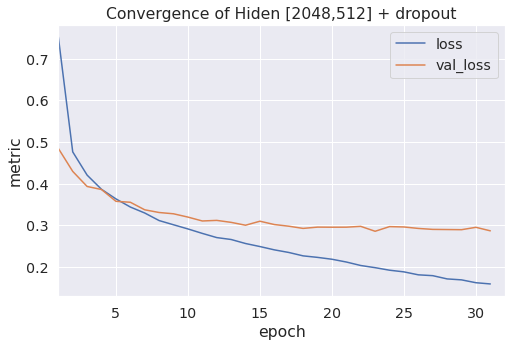

In [ ]:
best_deep_mlp_tuned.plot_history('loss')

The performance of the tuned model is:

In [ ]:
best_deep_mlp_tuned.evaluate(X_train_st, y_train, X_val_st, y_val, X_test_st, y_test)

,set,accuracy,precision,recall,f1
0,train,0.940625,0.941899,0.940625,0.940899
1,val,0.901500,0.902927,0.901500,0.901947
2,test,0.894400,0.896246,0.894400,0.894873


##Per class error analysis

Let's compare the performance of the best shallow model, the best model with 1 hidden layer and the model with tuned hyperparameters.

In [ ]:
def error_analysis(models, model_names):
    '''
    calculates the performance for each model and each class on the test set

    Parameters:
        models (list of MLP or CNN): the models which will be used for comparison
        model_names (list of strings): friendlier names for the models which will be used in the plots 
    '''

    #we will be using ggplot which is easier to work with using dataframes
    df = pd.DataFrame(columns = ['category', 'model', 'metric', 'score'])
    #iterate the models and the model names
    for model, model_name in zip(models, model_names):
        #MLP and CNN objects have different input shapes
        if type(model).__name__ == 'MLP':
            cr = classification_report(y_test, model.predict_class(X_test_st), output_dict=True)
        else:
            cr = classification_report(y_test, model.predict_class(X_test_cnn), output_dict=True)
        
        #data wrangling
        cr = pd.DataFrame(cr)
        cr = cr.iloc[:,:10]
        cr.columns = label_descr.values()
        cr = cr.T.reset_index()
        cr.columns = ['category', 'precision', 'recall', 'f1', 'support']
        cr['model'] = model_name
        cr = pd.melt(cr, id_vars=['category', 'model'], var_name='metric', value_name='score')
        cr = cr[cr.metric != 'support']
        df = pd.concat([df, cr])
    
    #plot the results
    (ggplot(df)+
     geom_col(aes(x='category', y='score', fill='model'), position = "dodge", width=0.8)+
     coord_flip(ylim=(0.6,1))+
     facet_wrap(facets='metric')+
     ylab('axis truncated[0.6,1]')+
     scale_fill_brewer(type='qual', palette='Set2')+
     ggtitle('Per Class Performance')+
     theme_minimal()
    ).draw()

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


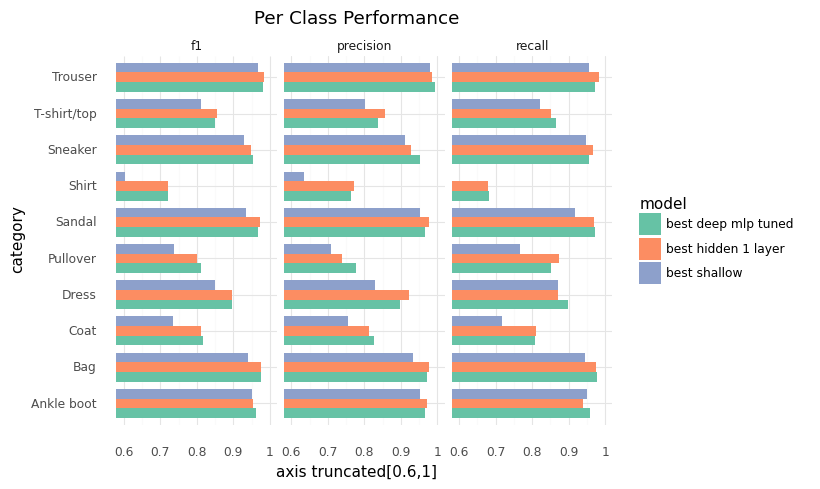

In [ ]:
error_analysis([best_shallow, best_hidden_1, best_deep_mlp_tuned], ['best shallow', 'best hidden 1 layer', 'best deep mlp tuned'])

Observations:

* The classes with the worst scores are shirts, pullovers and coats
* The shallow model does not perform well when compared with deeper MLPs
* We observe that in some classes, the `tuned MLP` achieves a better `f1` score, whereas in other classes, the MLP with just one hidden layer performs better. As a result, we can experiment with an ensemble of the two models, in case we are able to achieve a better performance. 

## Ensemble

We will combine the outcomes of two of our best models, add the prorbability distributions they predict for each instance of the test set and then take a softmax, in order to classify the instance.

In [ ]:
#add the probabilties of the two models
ensemble_predictions = best_deep_mlp_tuned.predict_proba(X_test_st) \
                        + best_hidden_1.predict_proba(X_test_st)

#softmax the sum of probabilities
ensemble_predictions = np.exp(ensemble_predictions) / np.sum(np.exp(ensemble_predictions), axis=1).reshape(-1,1)
#take the argmax to retrieve the predicted class
ensemble_predictions = np.argmax(ensemble_predictions, axis=1)

In [ ]:
scores = [
    accuracy_score(y_test,  best_hidden_1.predict_class(X_test_st))
    ,accuracy_score(y_test, best_deep_mlp_tuned.predict_class(X_test_st))
    ,accuracy_score(y_test, ensemble_predictions)
]
labels=['Hidden [512] + dropout', 'Hidden [2048, 512] + droput', 'Ensemble']
pd.DataFrame({'model':labels, 'score':scores})

,model,score
0,Hidden [512] + dropout,0.8923
1,"Hidden [2048, 512] + droput",0.8944
2,Ensemble,0.8960


We observe that by combining the probability distributions of the two models, we were able to achieve a better overall accuracy.

# CNNs

For the second task of the exercise, we will experiment with the use of Convolutional Neural Networks in order to handle the task at hand. First we have to reshape the input format into an acceptable shape for Keras. That is to reshape the flatten images back to [28,28,1]. The 3rd dimension is used for the number of filters during a `Conv2D` network, and since we have only one input channel, we use the number `1`.

In [ ]:
X_train_cnn = X_train_st.reshape(X_train_st.shape[0],N,N,1)
X_val_cnn = X_val_st.reshape(X_val_st.shape[0],N,N,1)
X_test_cnn = X_test_st.reshape(X_test_st.shape[0],N,N,1)

Then we will define a class which inheritcs from the ImageClassifer. This task takes care of compiling the model according to the parameters provided to the constructor.

In [ ]:
class CNN(ImageClassifier):

     def __init__(
         self
         ,optimizer
         ,conv_layers
         ,conv_activation
         ,residual_connections
         ,batch_norm
         ,max_pool_size
         ,filters
         ,kernel_sizes
         ,dense_layers
         ,hidden_activation
         ,conv_dropouts
         ,dense_dropouts
         ,name
         ,model_id
         ,output_activation='softmax'):
        '''
        the constructor takes care of compiling the model

        Paremeters:
            optimizer (tf.keras.optimizers): the optimizer for the fitting process, e.g. Adam, SGD
            conv_layers(iterable): the length of the list dictates the number of hidden layers 
                                      and each element the number of stacked CNN layers
            conv_activation(tf.keras.activations): the activation of the CNN layers
            residual_connections(iterable of boolean): the length should match the number of conv layers.
                                                        if True then there is a residual connection before the activation
            batch_norm(iterable): list of boolean values. If true, in the particular layer
                                   implement batch normalization 
            max_pool_size(tuple(n,m)): the size that the max pool operation will take place on the 2D feature map
            filters(int): number of feature per convolutional layer. if stacked the same number is used
            kernel_sizes(tuple(n,m)): the size of the rolling window which performs the convolution
            dense_layers(list of int): the length is the number of hidden layers and each elemen is the number of units
                                        of the corresponding hidden layer
            hidden_activation(tf.keras.activations): the activation function of all hidden layers

            dense_dropouts(iterable): list of dropout rates. should match in length the hidden_layers list 
            output_activation(tf.keras.activations): the activation of the last layer
            name(string): the name of the model, used in plotting function
            model_id(string): unique identified of the model. based on that, the ImageClassifier
                              checks whether there is history or weights for that model
        '''
        #initialize the subclass
        [setattr(self, name, value) for name, value in locals().items() if name != 'self']
        #initialize the constructor
        super(CNN, self).__init__(name, model_id)
        
        #set the seeds
        np.random.seed(1993)
        set_seed(1993)

        #start building the model using Keras' functional API
        input = Input(
            shape=(N,N,1)
            ,name='Input'
        )

        layer = 1
        x = input
        #first loop for the convolution layers
        for conv, filter, kernel_size, res_con, bn, dropout in zip(
                                                                    self.conv_layers
                                                                    ,self.filters
                                                                    ,self.kernel_sizes
                                                                    ,self.residual_connections
                                                                    ,self.batch_norm
                                                                    ,self.conv_dropouts):
            #second loop for the stacked convolutions
            for c in range(conv):
                #if the first iteration of the stacked iteration, keep the output to res
                #which will be used later as a residual connection
                if c == 0:
                    res = x

                x = Conv2D(
                    filters=filter,
                    kernel_size=kernel_size,
                    strides=(1, 1),
                    padding='same',
                    dilation_rate=(1, 1),
                    activation=None,
                    name=f'Conv2D_{layer}_{c+1}')(x)
            
            #if the residual connection element is True create a residual connection
            if res_con:
                #pass the output at the beginning of the convolution to another convolutions
                #with a kernel size of (1,1) to retain the features and as many layers as the convolution
                #it will be added to
                y = Conv2D(
                    filters=filter,
                    kernel_size=(1,1),
                    strides=(1, 1),
                    padding='valid',
                    dilation_rate=(1, 1),
                    activation=None,
                    name=f'Linear_{layer}')(res)
                #add the residual to the convolution layer
                x = Add(name=f'Residual_{layer}')([x, y])
                
            # if the element of the batch_norm is True then perform batch normalization
            if bn:
                x = BatchNormalization(axis=3, name = f'batch_norm_{layer}')(x)

            #activation function
            x = Activation(self.conv_activation, name=f'cov_activation_{layer}')(x)
            
            #max pooling
            x = MaxPool2D(
                pool_size=self.max_pool_size,
                strides=(2, 2),
                padding='same',
                name=f'MaxPool2D_{layer}')(x)
            #droput
            x = Dropout(rate=dropout, name=f'Dropout_{layer}')(x)
            layer+=1
        #after the convolutional layers have ended, flatten the output
        x = Flatten(name='Flatten')(x)
        
        layer=1
        #iterate through the dense layers
        for units, dropout in zip(self.dense_layers, self.dense_dropouts):
            x = Dense(units=units,
                      activation=None,
                      kernel_initializer = glorot_uniform(seed=1993),
                      name=f'Dense_{layer}'
                      )(x)
            #dropout of the dense layers
            x = Dropout(rate=dropout, name=f'Dropout_Dense_{layer}')(x)
            layer += 1
        #final output of the model
        output = Dense(
                units=N_CLASSES,
                activation = self.output_activation,
                name='output_layer'
            )(x)

        self.model = Model(inputs = input, outputs=output)
        self.model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

## Number of CNN layers

We will start experimenting with the number of convolutional layers, starting from 1. The number of filters is set to 128

In [ ]:
cnn_c1_h1 = CNN(
    Adam(learning_rate=1e-3)
    ,conv_layers=[1]
    ,residual_connections=[False]
    ,batch_norm = [False]
    ,max_pool_size=(2,2)
    ,filters=[128]
    ,kernel_sizes=[(3,3)]
    ,conv_dropouts=[0]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='1 Convolution layer'
    ,model_id='cnn_c1_h1'
)

cnn_c1_h1.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=60
    ,verbose=0
    #,early_stop_patience=8
    )

Then 2 Convolution Layers, with 64 and 128 filters respectively


In [ ]:
cnn_c2_h1 = CNN(
    Adam(learning_rate=1e-3)
    ,conv_layers=[1,1]
    ,residual_connections=[False,False]
    ,batch_norm = [False,False]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3),(3,3)]
    ,conv_dropouts=[0,0]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_h1'
)

cnn_c2_h1.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=60
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
cov_activation_2 (Activation (None, 14, 14, 128)       0  

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


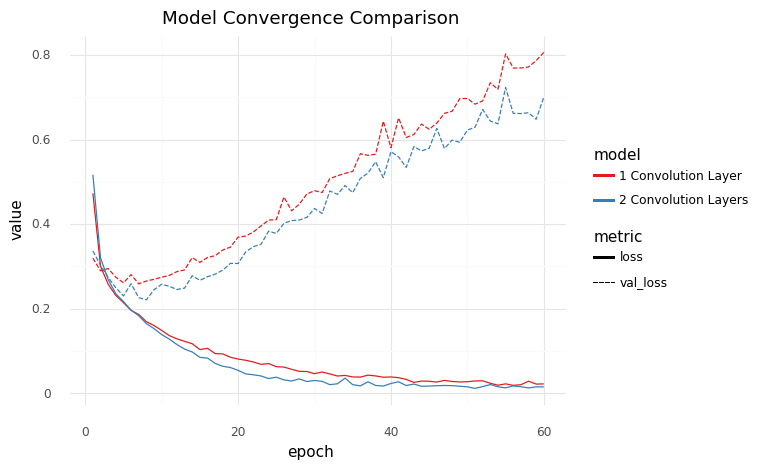

In [ ]:
plot_convergence_comparison(
    models=[cnn_c1_h1, cnn_c2_h1]
    ,model_names=['1 Convolution Layer', '2 Convolution Layers']
    ,metric='loss'
)

From the convergence, plot, we observe that the learning rate is high. We will refit with a smaller learning rate.

In [ ]:
cnn_c1_h1_lr0001 = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[1]
    ,residual_connections=[False]
    ,batch_norm = [False]
    ,max_pool_size=(2,2)
    ,filters=[128]
    ,kernel_sizes=[(3,3)]
    ,conv_dropouts=[0]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='1 Convolution layer'
    ,model_id='cnn_c1_h1_lr0001'
)

cnn_c1_h1_lr0001.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=60
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 128)       1280      
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 128)       0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 128)       0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
Flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               6422

In [ ]:
cnn_c2_h1_lr0001 = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[1,1]
    ,residual_connections=[False,False]
    ,batch_norm = [False,False]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3),(3,3)]
    ,conv_dropouts=[0,0]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_h1_lr0001'
)

cnn_c2_h1_lr0001.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=60
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
cov_activation_2 (Activation (None, 14, 14, 128)       0   

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


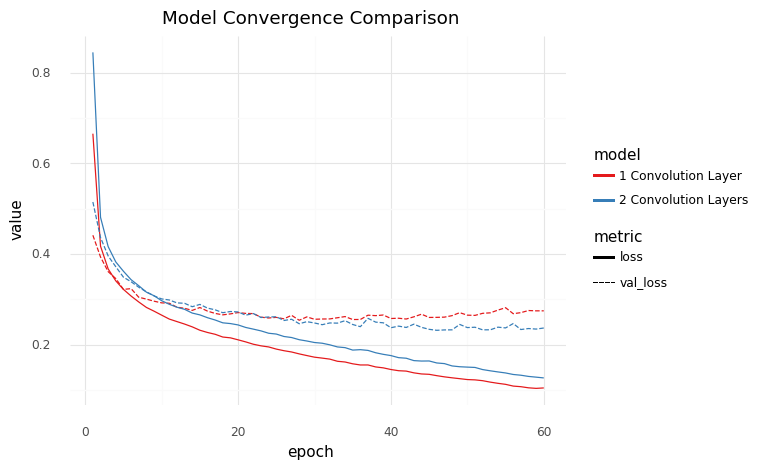

In [ ]:
plot_convergence_comparison(
    models=[cnn_c1_h1_lr0001, cnn_c2_h1_lr0001]
    ,model_names=['1 Convolution Layer', '2 Convolution Layers']
    ,metric='loss'
)

We observe that with just one convolution layer, the model has reached its learning capacity, whereas using 2 convolution layers we observe that the model keeps learning. Additionally, both CNNs tend to overfit, so it would be wise to add Dropouts. Let's compare the performance of the 2 models, together with tuned deep MLP:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


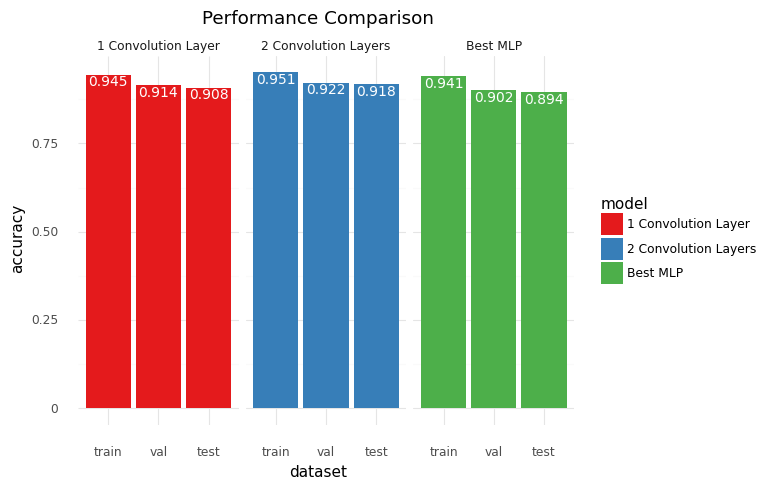

In [ ]:
plot_performance_comparison(
    models=[best_deep_mlp_tuned, cnn_c1_h1_lr0001, cnn_c2_h1_lr0001]
    ,model_names=['Best MLP', '1 Convolution Layer', '2 Convolution Layers']
    ,metric='accuracy'
)

We can observe that without any tuning and with very simple architectures, the Convlutional Neural Networks manage to overperform the MLP after tuning. We will try to push their performance even more, by adding dropout, performing batch normalization and adding more dense layers after the flatenning layer.

## Addition of Dropout

Retaining the CNN with 2 convolution layers, we will enhance it by adding dropout after the pooling layer.

In [ ]:
cnn_c2_h1_lr0001_dr = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[1,1]
    ,residual_connections=[False,False]
    ,batch_norm = [False,False]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3),(3,3)]
    ,conv_dropouts=[0.3,0.3]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_h1_lr0001_dr'
)

cnn_c2_h1_lr0001_dr.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=100
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 128)       73856     
_________________________________________________________________
cov_activation_2 (Activation (None, 14, 14, 128)       0     

The convergence when compared with the same model without dropout is:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


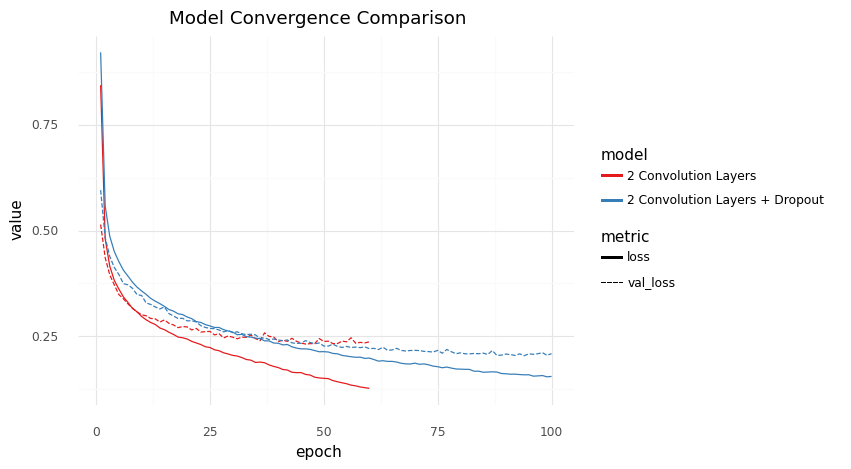

In [ ]:
plot_convergence_comparison(
    models=[cnn_c2_h1_lr0001, cnn_c2_h1_lr0001_dr]
    ,model_names=['2 Convolution Layers', '2 Convolution Layers + Dropout']
    ,metric='loss'
)

We can observe that the CNN with the dropout rate overfits much slower. However, it takes many epochs to train. For that reason, we might consider later to increase the dropout rate.

The performance of the two models is:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


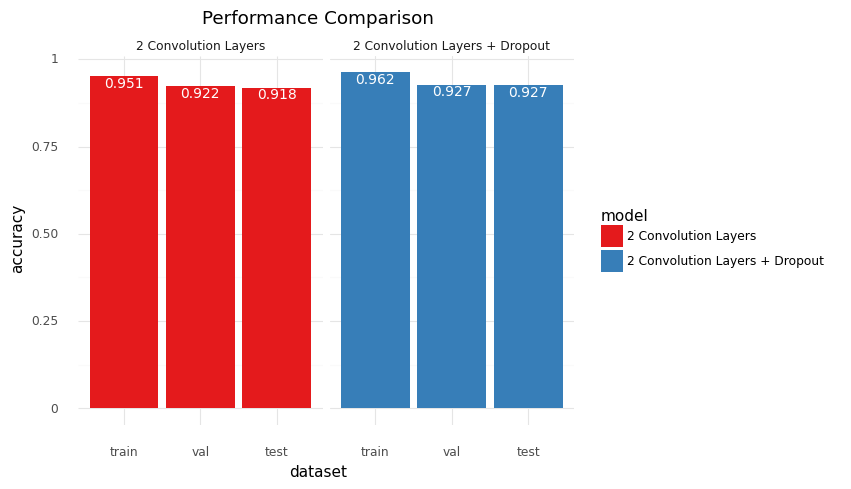

In [ ]:
plot_performance_comparison(
    models=[cnn_c2_h1_lr0001, cnn_c2_h1_lr0001_dr]
    ,model_names=['2 Convolution Layers', '2 Convolution Layers + Dropout']
    ,metric='accuracy'
)

The accuracy on the test set, after adding dropout, increased from `0.918` to `0.927`.

## Batch Normalization

We will fit a network without dropout.

In [ ]:
cnn_c2_h1_lr0001_bn = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[1,1]
    ,residual_connections=[False,False]
    ,batch_norm = [True,True]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3),(3,3)]
    ,conv_dropouts=[0,0]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_h1_lr0001_bn'
)

cnn_c2_h1_lr0001_bn.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=100
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 28, 28, 64)        256       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 128)       7385

And then a layer with dropout.

In [ ]:
cnn_c2_h1_lr0001_dr_bn = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[1,1]
    ,residual_connections=[False,False]
    ,batch_norm = [True,True]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3),(3,3)]
    ,conv_dropouts=[0.3,0.3]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_h1_lr0001_dr_bn'
)

cnn_c2_h1_lr0001_dr_bn.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=256
    ,epochs=100
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 28, 28, 64)        256       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 128)       7385

The convergence plots are:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


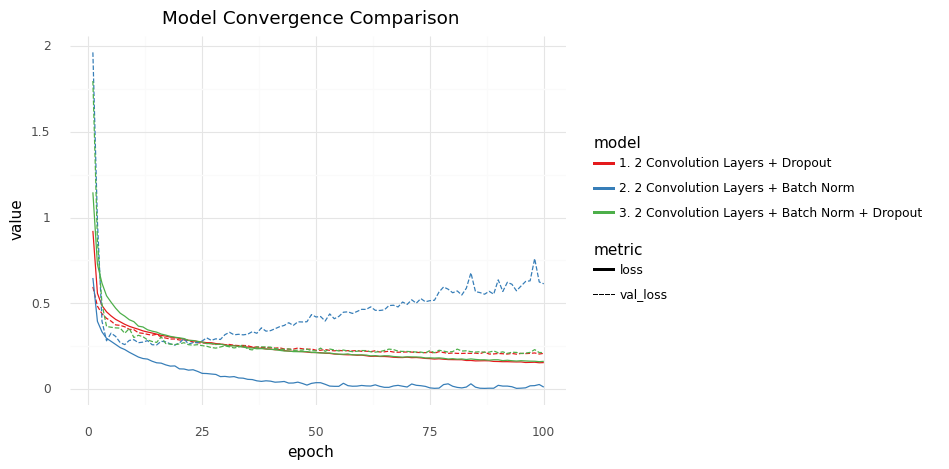

In [ ]:
plot_convergence_comparison(
    models=[cnn_c2_h1_lr0001_dr, cnn_c2_h1_lr0001_bn, cnn_c2_h1_lr0001_dr_bn]
    ,model_names=['1. 2 Convolution Layers + Dropout', '2. 2 Convolution Layers + Batch Norm', '3. 2 Convolution Layers + Batch Norm + Dropout']
    ,metric='loss'
)

Observations:

* The model which uses only Batch Normalization converges much faster. Batch normalization has actually reduced the covariance shift, leading to a local minimum much faster.
* When Batch Norm is compared with dropout, the effects of the Batch Norm are not evident, since the two models have almost the same speed of convergence.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


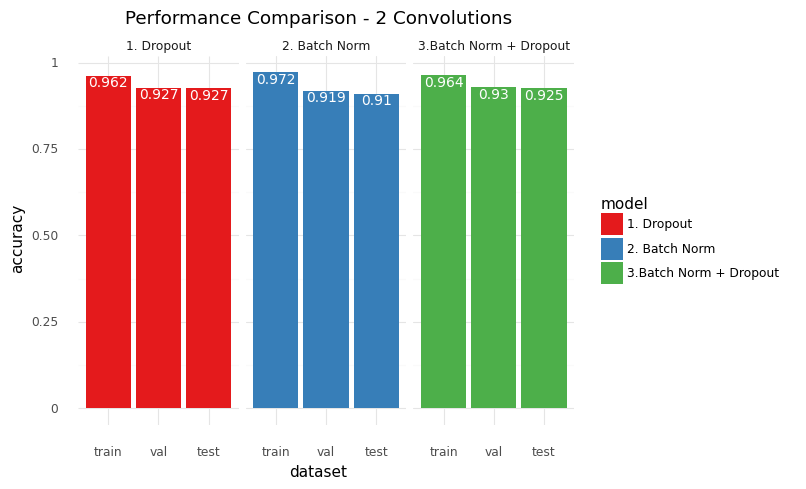

In [ ]:
plot_performance_comparison(
    models=[cnn_c2_h1_lr0001_dr, cnn_c2_h1_lr0001_bn, cnn_c2_h1_lr0001_dr_bn]
    ,model_names=['1. Dropout', '2. Batch Norm', '3.Batch Norm + Dropout']
    ,metric='accuracy'
    ,caption=' - 2 Convolutions'
)

In terms of performance, the model with just dropout is the best performing.

## Stacking and Residual Connections

In this section we will experiment with the idea of stacking Convolutional Layers and connecting them with residual connections.

In [ ]:
cnn_c2_stacked_h1_lr0001 = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[2, 2]
    ,residual_connections=[True, True]
    ,batch_norm = [False, False]
    ,max_pool_size=(2,2)
    ,filters=[64, 128]
    ,kernel_sizes=[(3,3), (3,3)]
    ,conv_dropouts=[0.3, 0.3]
    ,conv_activation='relu'
    ,dense_layers=[256]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c2_stacked_h1_lr0001'
)

cnn_c2_stacked_h1_lr0001.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=512
    ,epochs=200
    ,verbose=1
    #,early_stop_patience=8
    )

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1_1 (Conv2D)             (None, 28, 28, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1_2 (Conv2D)             (None, 28, 28, 64)   36928       Conv2D_1_1[0][0]                 
__________________________________________________________________________________________________
Linear_1 (Conv2D)               (None, 28, 28, 64)   128         Input[0][0]                      
____________________________________________________________________________________________

In [ ]:
cnn_c3_stacked_h2_lr0001 = CNN(
    Adam(learning_rate=1e-4)
    ,conv_layers=[2, 2, 2]
    ,residual_connections=[True, True, True]
    ,batch_norm = [False, False, False]
    ,max_pool_size=(2,2)
    ,filters=[64, 128, 256]
    ,kernel_sizes=[(3,3), (3,3), (3,3)]
    ,conv_dropouts=[0.3, 0.3, 0.3]
    ,conv_activation='relu'
    ,dense_layers=[256, 128]
    ,hidden_activation='relu'
    ,dense_dropouts=[0.3, 0.3]
    ,name='2 Convolution layer'
    ,model_id='cnn_c3_stacked_h2_lr0001'
)

cnn_c3_stacked_h2_lr0001.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot
    ,batch_size=512
    ,epochs=200
    ,verbose=0
    #,early_stop_patience=8
    )

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1_1 (Conv2D)             (None, 28, 28, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1_2 (Conv2D)             (None, 28, 28, 64)   36928       Conv2D_1_1[0][0]                 
__________________________________________________________________________________________________
Linear_1 (Conv2D)               (None, 28, 28, 64)   128         Input[0][0]                      
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


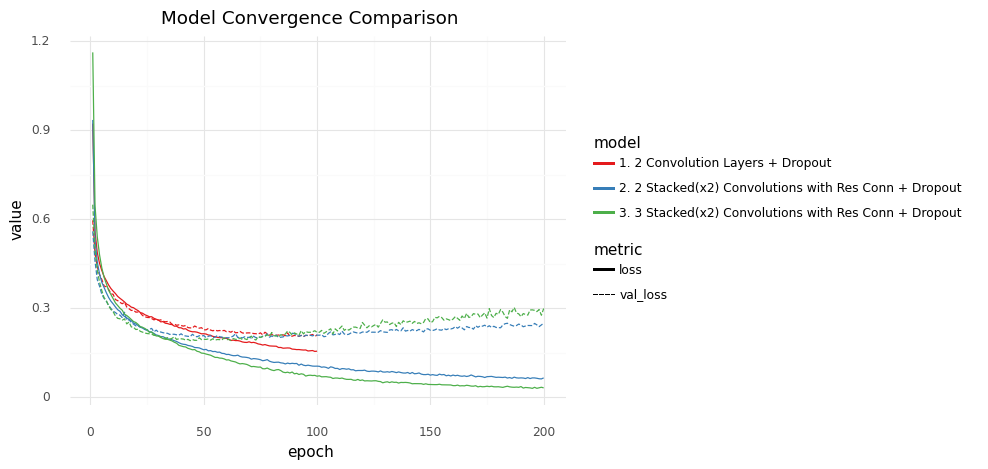

In [ ]:
plot_convergence_comparison(
    models=[cnn_c2_h1_lr0001_dr, cnn_c2_stacked_h1_lr0001, cnn_c3_stacked_h2_lr0001]
    ,model_names=['1. 2 Convolution Layers + Dropout', '2. 2 Stacked(x2) Convolutions with Res Conn + Dropout', '3. 3 Stacked(x2) Convolutions with Res Conn + Dropout']
    ,metric='loss'
)

From the convergenece plot we observe that the model with the 2 stacked(x2) convolution layers and the residual achieved lower losses, than the simpler model with 2 convolution layers. Slightly better results are observed from the model with 3 layers of Stacked convolutions and `2` dense layers.

The performance of the models is:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


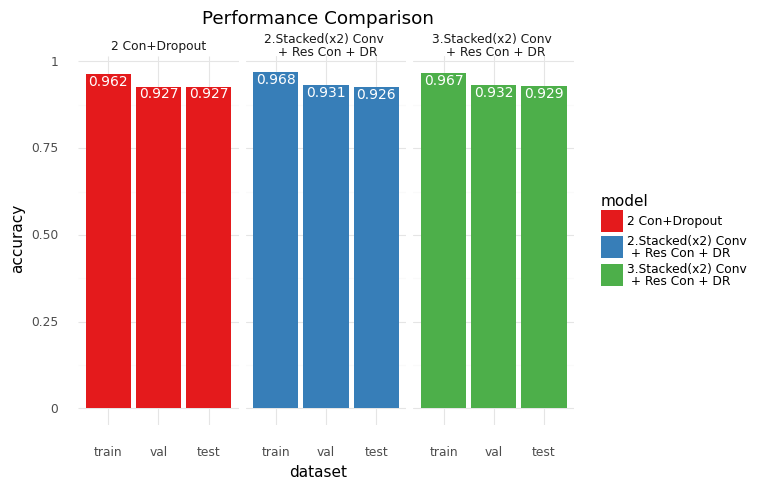

In [ ]:
plot_performance_comparison(
   models=[cnn_c2_h1_lr0001_dr, cnn_c2_stacked_h1_lr0001, cnn_c3_stacked_h2_lr0001]
    ,model_names=['2 Con+Dropout', '2.Stacked(x2) Conv \n + Res Con + DR', '3.Stacked(x2) Conv \n + Res Con + DR']
    ,metric='accuracy'
    ,caption=''
)

In terms of performance, there is no significant difference between the two models. However, the model with the 3 layers of stacked convolutions and residual connections has the best performance on the test set.

## Hypertuning a CNN

For the CNN models, we will hypertune 2 different architectures:
 
* A model with 3 max convolution layers, where we will tune the number of filters, as well as the dropout rates
* A model with 3 max layers of stacked convolutions and residuals connections, where we will tune the number of filters as well as the drop out rates

###Convolution Layers Tuning

First we need to find a good estimate for the patience of early stopping.

In [ ]:
#get the validation loss from the history
cnn_c2_h1_lr0001_dr_loss = pd.DataFrame(cnn_c2_h1_lr0001_dr.hs.history['val_loss'], columns=['val_loss'])
#calculate the "cummulative" minimum
cnn_c2_h1_lr0001_dr_loss['running_min'] = cnn_c2_h1_lr0001_dr_loss.cummin()
#group by the cummulative minimum, in order to find for how many epochs it stayed as the minimum loss
freqs = cnn_c2_h1_lr0001_dr_loss.groupby('running_min').agg(minimum_loss_for_period = ('running_min', 'count')).reset_index()
freqs.sort_values(by='minimum_loss_for_period', ascending=False).head(10)

,running_min,minimum_loss_for_period
0,0.203920,7
1,0.204610,6
3,0.208205,4
10,0.215054,4
22,0.233148,4
6,0.209780,3
12,0.216725,3
43,0.314627,2
32,0.260298,2
31,0.258610,2


From the results we can understand that the model could not have possibly converged yet, since we do not see a local minimum which lasted for a large number of epochs. In order to be safe, we will use a high number for the patience parameter, like `15`.

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

class CNNTuner(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        hp_conv_1 = hp.Int('filters_1', min_value=32, max_value=64, step=16)
        hp_conv_2 = hp.Int('filters_2', min_value=64, max_value=128, step=32)
        hp_conv_3 = hp.Int('filters_3', min_value=128, max_value=256, step=64)
        conv_filters = [hp_conv_1, hp_conv_2, hp_conv_3]

        hp_dropout_1 = hp.Float('dropout_1', min_value=0, max_value=0.2, step=0.1)
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.2)
        hp_dropout_3 = hp.Float('dropout_3', min_value=0.2, max_value=0.4, step=0.2)
        dropout_rates = [0, hp_dropout_1, hp_dropout_2, hp_dropout_3]
        
        hp_batch_norm = hp.Boolean('batch_norm', default=False)
        num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=3)
        
        hp_dense_units = hp.Int('dense_units', min_value=256, max_value=1024, step=128)
        hp_dense_dropout = hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    
        hypermodel = CNN(
                        Adam(learning_rate=hp_learning_rate)
                        ,conv_layers=[1] * num_conv_layers
                        ,residual_connections=[False] * num_conv_layers
                        ,batch_norm = [hp_batch_norm] * num_conv_layers
                        ,max_pool_size=(2,2)
                        ,filters=conv_filters[:num_conv_layers]
                        ,kernel_sizes = [(3,3)] * num_conv_layers
                        ,conv_dropouts = dropout_rates[:num_conv_layers+1]
                        ,conv_activation='relu'
                        ,dense_layers=[hp_dense_units]
                        ,hidden_activation='relu'
                        ,dense_dropouts=[hp_dense_dropout]
                        ,name='2 Convolution layer'
                        ,model_id='CNN_2_layer_tuned'
                    )

        return hypermodel.model


In [ ]:
import shutil
shutil.rmtree('MLP_Fashion_MNIST')

In [ ]:
cnn_hyper = CNNTuner(num_classes=10)

tuner = BayesianOptimization(
    cnn_hyper,
    objective='val_accuracy',
    max_trials=30,
    directory='MLP_Fashion_MNIST',
    project_name='MLP',
    seed = 1234,
)


tuner.search(X_train_cnn, y_train_one_hot,
            epochs=150,
            validation_data=(X_val_cnn, y_val_one_hot),
            batch_size=256,
            callbacks=[
                EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max')
                ]
            )

Trial 30 Complete [00h 02m 53s]
val_accuracy: 0.9294999837875366

Best val_accuracy So Far: 0.9340000152587891
Total elapsed time: 01h 37m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in MLP_Fashion_MNIST/MLP
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 64
filters_2: 64
filters_3: 128
dropout_1: 0.2
dropout_2: 0.4
dropout_3: 0.4
batch_norm: False
num_conv_layers: 3
dense_units: 896
learning_rate: 0.001
Score: 0.9340000152587891


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

print(best_model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
cov_activation_2 (Activation (None, 14, 14, 64)        0     

In [ ]:
#initiate the custom class
best_cnn_tuned = CNN(
                      Adam(learning_rate=1e-3)
                      ,conv_layers=[1,1,1]
                      ,residual_connections=[False, False, False]
                      ,batch_norm = [False, False, False]
                      ,max_pool_size=(2,2)
                      ,filters=[64,64,128]
                      ,kernel_sizes = [(3,3), (3,3), (3,3)]
                      ,conv_dropouts = [0.2,0.4,0.4]
                      ,conv_activation='relu'
                      ,dense_layers=[896]
                      ,hidden_activation='relu'
                      ,dense_dropouts=[0.4]
                      ,name='Best CNN Tuned'
                      ,model_id='best_cnn_tuned'
                    )

#fit the model
best_cnn_tuned.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot

    ,batch_size= 256
    ,epochs=150
    ,verbose=0
    ,early_stop_patience=15
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Conv2D_1_1 (Conv2D)          (None, 28, 28, 64)        640       
_________________________________________________________________
cov_activation_1 (Activation (None, 28, 28, 64)        0         
_________________________________________________________________
MaxPool2D_1 (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
Conv2D_2_1 (Conv2D)          (None, 14, 14, 64)        36928     
_________________________________________________________________
cov_activation_2 (Activation (None, 14, 14, 64)        0     

The convergence plot is:

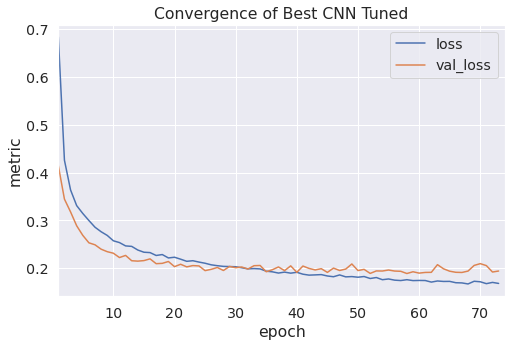

In [ ]:
best_cnn_tuned.plot_history('loss')

The performance of the model is:

In [ ]:
best_cnn_tuned.evaluate(
    X_train_cnn
    ,y_train
    ,X_val_cnn
    ,y_val
    ,X_test_cnn
    ,y_test
)

,set,accuracy,precision,recall,f1
0,train,0.969708,0.970038,0.969708,0.969801
1,val,0.933167,0.933886,0.933167,0.933414
2,test,0.926800,0.927751,0.926800,0.927089


### Stacked convolutions with Residual connections

In [ ]:
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from kerastuner import Objective

class StackedCNNTuner(HyperModel):

    def __init__(self, num_classes):
        self.num_classes = num_classes

    def build(self, hp):
        hp_conv_1 = hp.Int('filters_1', min_value=32, max_value=64, step=16)
        hp_conv_2 = hp.Int('filters_2', min_value=64, max_value=128, step=32)
        hp_conv_3 = hp.Int('filters_3', min_value=128, max_value=256, step=64)
        conv_filters = [hp_conv_1, hp_conv_2, hp_conv_3]
        hp_stacked_conv = hp.Int('stacked_conv', min_value=2, max_value=3, step=1)
        
        hp_dropout_1 = hp.Float('dropout_1', min_value=0, max_value=0.2, step=0.1)
        hp_dropout_2 = hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.2)
        hp_dropout_3 = hp.Float('dropout_3', min_value=0.2, max_value=0.4, step=0.2)
        dropout_rates = [0, hp_dropout_1, hp_dropout_2, hp_dropout_3]
        
        num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=3)
        
        hp_dense_units = hp.Int('dense_units', min_value=256, max_value=1024, step=128)
        hp_dense_dropout = hp.Float('dropout_2', min_value=0.2, max_value=0.4, step=0.1)
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    
        hypermodel = CNN(
                        Adam(learning_rate=hp_learning_rate)
                        ,conv_layers=[hp_stacked_conv] * num_conv_layers
                        ,residual_connections=[True] * num_conv_layers
                        ,batch_norm = [False] * num_conv_layers
                        ,max_pool_size=(2,2)
                        ,filters=conv_filters[:num_conv_layers]
                        ,kernel_sizes = [(3,3)] * num_conv_layers
                        ,conv_dropouts = dropout_rates[:num_conv_layers+1]
                        ,conv_activation='relu'
                        ,dense_layers=[hp_dense_units]
                        ,hidden_activation='relu'
                        ,dense_dropouts=[hp_dense_dropout]
                        ,name='stacked Convolution layer'
                        ,model_id='CNN_stacked_tuned'
                    )

        return hypermodel.model


In [ ]:
import shutil
shutil.rmtree('stacked_cnn')

In [ ]:
stacked_cnn_hyper = StackedCNNTuner(num_classes=10)

tuner = BayesianOptimization(
    stacked_cnn_hyper,
    objective='val_accuracy',
    max_trials=20,
    directory='stacked_cnn',
    project_name='CNN',
    seed = 1234,
)


tuner.search(X_train_cnn, y_train_one_hot,
            epochs=150,
            validation_data=(X_val_cnn, y_val_one_hot),
            batch_size=256,
            callbacks=[
                EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='max')
                ]
            )

Trial 20 Complete [00h 03m 44s]
val_accuracy: 0.9259166717529297

Best val_accuracy So Far: 0.9330000281333923
Total elapsed time: 01h 24m 18s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in stacked_cnn/CNN
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
filters_1: 64
filters_2: 128
filters_3: 256
stacked_conv: 2
dropout_1: 0.1
dropout_2: 0.4
dropout_3: 0.4
num_conv_layers: 3
dense_units: 1024
learning_rate: 0.0001
Score: 0.9330000281333923


In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)

print(best_model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1_1 (Conv2D)             (None, 28, 28, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1_2 (Conv2D)             (None, 28, 28, 64)   36928       Conv2D_1_1[0][0]                 
__________________________________________________________________________________________________
Linear_1 (Conv2D)               (None, 28, 28, 64)   128         Input[0][0]                      
______________________________________________________________________________________________

In [ ]:
#initiate the custom class
best_stacked_cnn_tuned = CNN(
                      Adam(learning_rate=1e-4)
                      ,conv_layers=[2,2,2]
                      ,residual_connections=[True, True, True]
                      ,batch_norm = [False, False, False]
                      ,max_pool_size=(2,2)
                      ,filters=[64,128,256]
                      ,kernel_sizes = [(3,3), (3,3), (3,3)]
                      ,conv_dropouts = [0.1,0.4,0.4]
                      ,conv_activation='relu'
                      ,dense_layers=[124]
                      ,hidden_activation='relu'
                      ,dense_dropouts=[0.4]
                      ,name='Best CNN Tuned'
                      ,model_id='best_stacked_cnn_tuned'
                    )

#fit the model
best_stacked_cnn_tuned.fit(
    X_train=X_train_cnn
    ,y_train = y_train_one_hot
    ,X_val = X_val_cnn
    ,y_val = y_val_one_hot

    ,batch_size= 256
    ,epochs=150
    ,verbose=0
    ,early_stop_patience=15
)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1_1 (Conv2D)             (None, 28, 28, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1_2 (Conv2D)             (None, 28, 28, 64)   36928       Conv2D_1_1[0][0]                 
__________________________________________________________________________________________________
Linear_1 (Conv2D)               (None, 28, 28, 64)   128         Input[0][0]                      
____________________________________________________________________________________________

The convergence plot is:

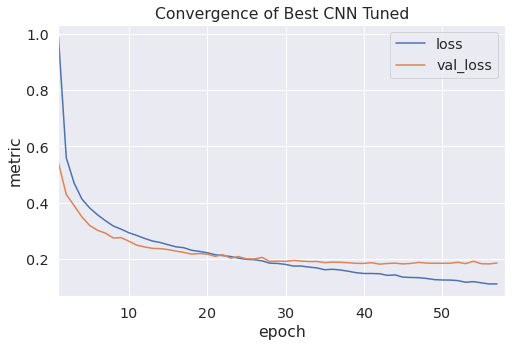

In [ ]:
best_stacked_cnn_tuned.plot_history('loss')

The performance of the model is:

In [ ]:
best_stacked_cnn_tuned.evaluate(
    X_train_cnn
    ,y_train
    ,X_val_cnn
    ,y_val
    ,X_test_cnn
    ,y_test
)

,set,accuracy,precision,recall,f1
0,train,0.972604,0.972719,0.972604,0.972609
1,val,0.935167,0.935272,0.935167,0.935147
2,test,0.931000,0.931140,0.931000,0.930924


Comparing the performance of the two optimized CNNs, together with the tuned MLP we obtain:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


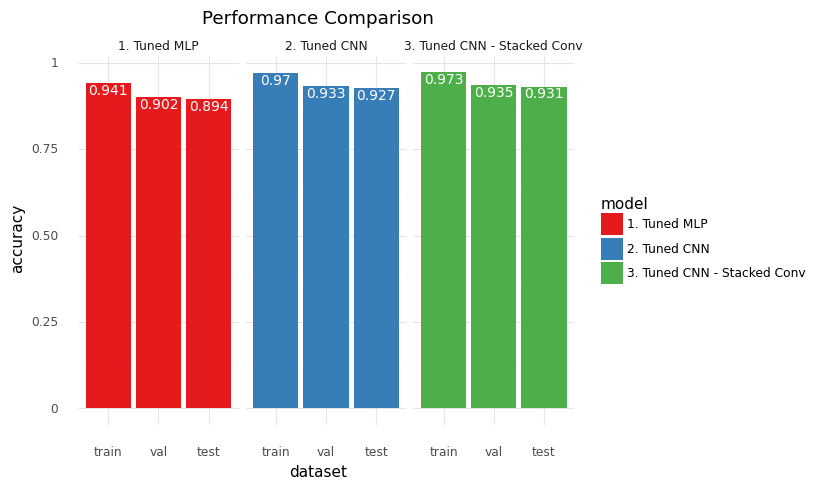

In [ ]:
plot_performance_comparison(
    models = [best_deep_mlp_tuned, best_cnn_tuned, best_stacked_cnn_tuned]
    ,model_names = ['1. Tuned MLP', '2. Tuned CNN', '3. Tuned CNN - Stacked Conv']
    ,metric='accuracy'
)

We observe that the model with the best performance is the CNN which uses stacked convolutions as well as residual connections.

In [ ]:
best_stacked_cnn_tuned.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1_1 (Conv2D)             (None, 28, 28, 64)   640         Input[0][0]                      
__________________________________________________________________________________________________
Conv2D_1_2 (Conv2D)             (None, 28, 28, 64)   36928       Conv2D_1_1[0][0]                 
__________________________________________________________________________________________________
Linear_1 (Conv2D)               (None, 28, 28, 64)   128         Input[0][0]                      
____________________________________________________________________________________________

The architecture of the model is:

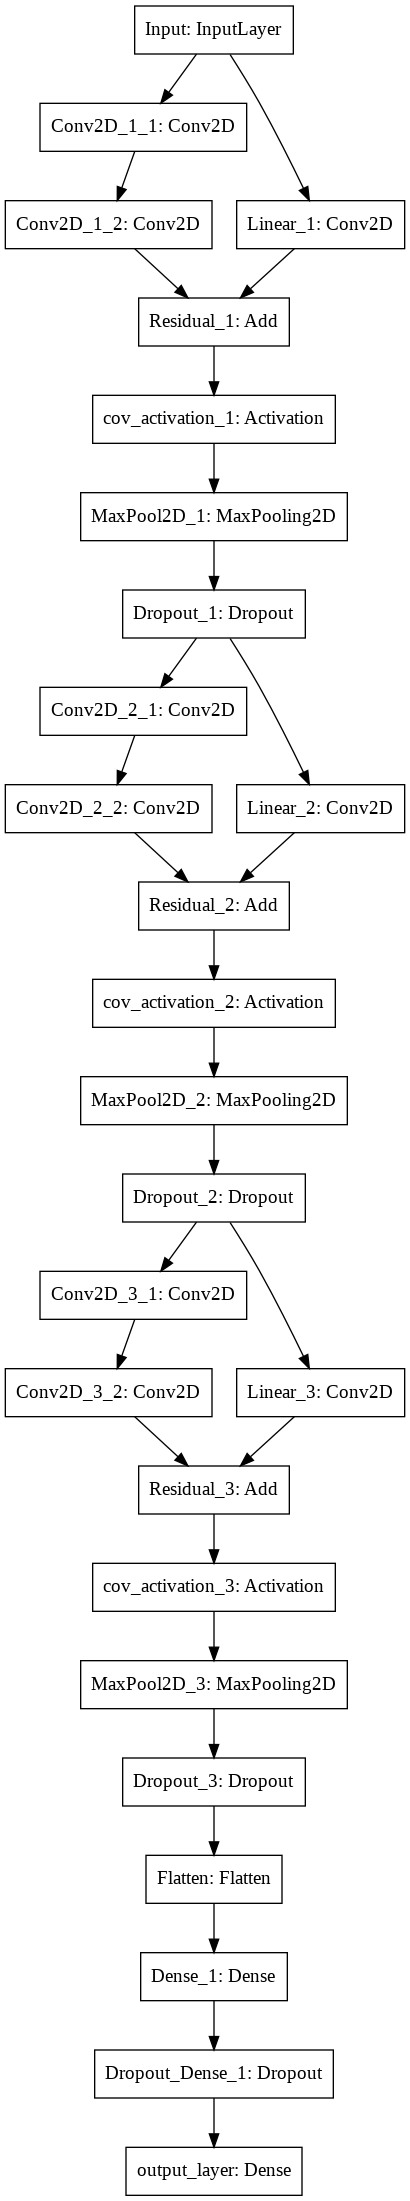

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(best_stacked_cnn_tuned.model)

## Per Class Error Analysis

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


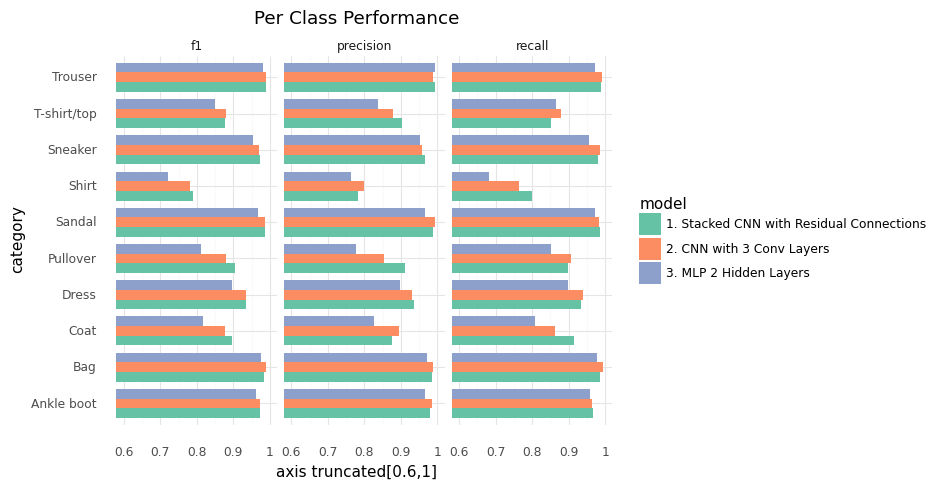

In [ ]:
error_analysis(
    [best_stacked_cnn_tuned, best_cnn_tuned ,best_deep_mlp_tuned]
    ,['1. Stacked CNN with Residual Connections', '2. CNN with 3 Conv Layers', '3. MLP 2 Hidden Layers']
)

we observe that the CNN models outperform the deep MLP model. Additionally, even though in most of the classed the Stacked CNN with residual connections has better performance, there are still classes where the simpler CNN with 3 convolutions has better f1 scores. For that reason, we can experiment with an ensemble using the combined output of the two CNNs.

## Ensemble

In [ ]:
ensemble_predictions = best_cnn_tuned.predict_proba(X_test_cnn) \
                        + best_stacked_cnn_tuned.predict_proba(X_test_cnn)

ensemble_predictions = np.exp(ensemble_predictions) / np.sum(np.exp(ensemble_predictions), axis=1).reshape(-1,1)
ensemble_class_predictions = np.argmax(ensemble_predictions, axis=1)

In [ ]:
scores = [
    accuracy_score(y_test,  best_cnn_tuned.predict_class(X_test_cnn))
    ,accuracy_score(y_test, best_stacked_cnn_tuned.predict_class(X_test_cnn))
    ,accuracy_score(y_test, ensemble_class_predictions)
]
labels=['3 Conv Layers', '3 stacked(x2) Conv layers + Residual Connections', 'Ensemble']
pd.DataFrame({'model':labels, 'score':scores})

,model,score
0,3 Conv Layers,0.9268
1,3 stacked(x2) Conv layers + Residual Connections,0.9310
2,Ensemble,0.9344


We observe that we pushed the performance further from, `0.9310` to `0.9344` by using a very simple ensemble technique.

# Data Augmentation
We will also experiment with the technique of data augmentation. That is to perform various transformations to the input images, like rotation, flip, blurring or rescaling

In [ ]:
resize_and_rescale = Sequential([
  experimental.preprocessing.RandomFlip("horizontal"),
  experimental.preprocessing.RandomRotation(factor=0.1),
  experimental.preprocessing.RandomContrast(0.1),
  experimental.preprocessing.RandomZoom(0.2)
])

We will augment the train, validation and test data.

In [ ]:
def augment(X):
    augmented_1 = np.array(resize_and_rescale(X))
    augmented_2 = np.array(resize_and_rescale(X))
    X_aug = np.vstack([X, augmented_1, augmented_2])
    return X_aug

X_train_cnn_aug = augment(X_train_cnn)
X_val_cnn_aug = augment(X_val_cnn)
X_test_cnn_aug = augment(X_test_cnn)
y_train_one_hot_aug = np.vstack([y_train_one_hot, y_train_one_hot, y_train_one_hot])
y_val_one_hot_aug = np.vstack([y_val_one_hot, y_val_one_hot, y_val_one_hot])
y_test_one_hot_aug = np.vstack([y_test_one_hot, y_test_one_hot, y_test_one_hot])
y_train_aug = np.concatenate([y_train, y_train, y_train], axis=0)
y_val_aug = np.concatenate([y_val, y_val, y_val], axis=0)
y_test_aug = np.concatenate([y_test, y_test, y_test], axis=0)

Here are some examples of augmentation.

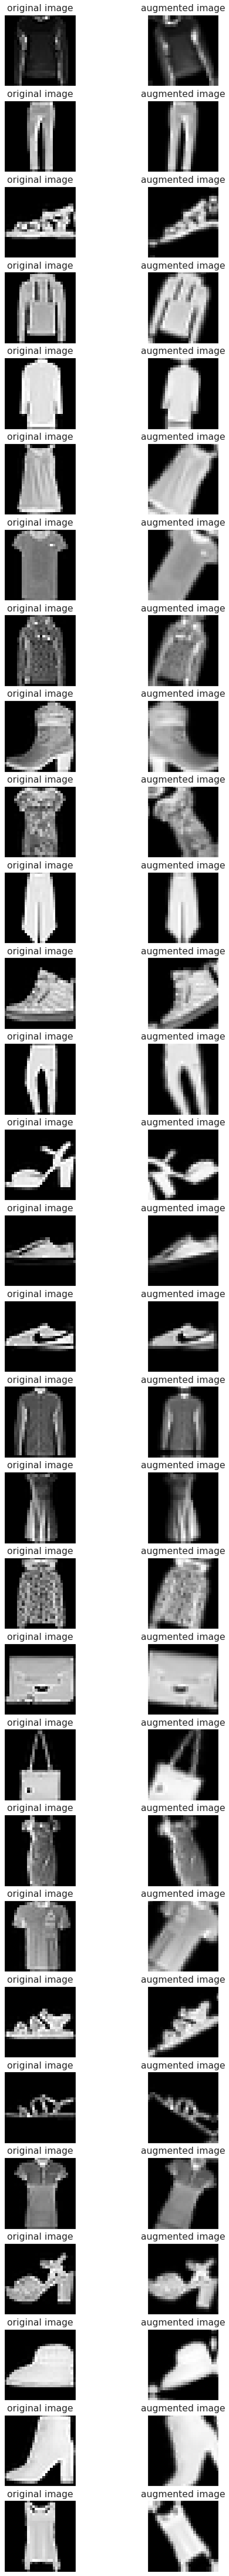

In [ ]:
examples = resize_and_rescale(X_train_cnn)
fig, axs = plt.subplots(30,2, figsize=(8,80))
for i in range(30):
    axs[i][0].imshow(X_train_cnn[i,:,:,0], cmap='gray')
    axs[i][0].title.set_text('original image')
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].title.set_text('augmented image')
    axs[i][1].imshow(examples[i,:,:,0],  cmap='gray')
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])

Now let's train our model.

In [ ]:
#initiate the custom class
cnn_aug = CNN(
                Adam(learning_rate=1e-4)
                ,conv_layers=[2,2,2]
                ,residual_connections=[True, True, True]
                ,batch_norm = [False, False, False]
                ,max_pool_size=(2,2)
                ,filters=[64,128,256]
                ,kernel_sizes = [(3,3), (3,3), (3,3)]
                ,conv_dropouts = [0.1,0.4,0.4]
                ,conv_activation='relu'
                ,dense_layers=[124]
                ,hidden_activation='relu'
                ,dense_dropouts=[0.4]
                ,name='CNN with augmented data'
                ,model_id='cnn_aug'
                    )

#fit the model
cnn_aug.fit(
    X_train=X_train_cnn_aug
    ,y_train = y_train_one_hot_aug
    ,X_val = X_val_cnn_aug
    ,y_val = y_val_one_hot_aug

    ,batch_size = 1024
    ,epochs = 150
    ,verbose = 1
    ,early_stop_patience=15
)

Since we augmented the test as as well, we will keep the `mode` of each test instance, that is the most frequent class prediction between the actual test instances and the 2 augmented instances.

In [ ]:
predictions_aug = cnn_aug.predict_class(X_test_cnn_aug)
predictions_aug = pd.DataFrame(predictions_aug.reshape(len(y_test), 3, order='F')
  ,columns = ['pred_1', 'pred_2', 'pred_3']
)
predictions_aug['prediction'] = predictions_aug.mode(axis=1).iloc[:,0]

In [ ]:
scores = [
    accuracy_score(y_test,  predictions_aug.prediction)
    ,accuracy_score(y_test, best_stacked_cnn_tuned.predict_class(X_test_cnn))
]
labels=['No Augmentation', 'Augmented data']
pd.DataFrame({'model':labels, 'score':scores})

,model,score
0,No Augmentation,0.921
1,Augmented data,0.931


We can observe that using augmented data did not enhance the performance as expected.